In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from google.colab import drive

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess data
L = 1
T = 20
nx = 512
nt = 199
dx = L / (nx - 1)
dt = 0.1

# Load and preprocess data
data_path = './integrated_shear_flow_2_Reynolds_5e5_Schmidt_2e-1.npy' # Path in Google Drive
data = np.load(data_path)
data = (data - data.mean()) / data.std()

total_time_steps = data.shape[1]
input_data = data[:, :total_time_steps//2, :]
target_data = data[:, total_time_steps//2:, :]

input_tensor = torch.tensor(input_data[:, np.newaxis, :, :], dtype=torch.float32)
target_tensor = torch.tensor(target_data[:, np.newaxis, :, :], dtype=torch.float32)

# Dataset and loaders
dataset = TensorDataset(input_tensor, target_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(50))
# train_loader = DataLoader(train_dataset, batch_size=train_size)
train_loader = DataLoader(train_dataset, batch_size=5)
test_loader = DataLoader(test_dataset, batch_size=test_size)

Mounted at /content/drive


In [3]:
train_size, test_size

(12, 4)

In [4]:
class FirstOrderDerivative(nn.Module):
    def __init__(self, h=1.0):
        super(FirstOrderDerivative, self).__init__()
        self.Nstencil = 3
        stencil_vals = torch.tensor([-1/(h), 1/(h), 0], dtype=torch.float32)  # ← float32 here
        self.stencil = nn.Parameter(stencil_vals.view(1, 1, -1))  # [out_channels, in_channels, kernel_size]

    def forward(self, x, h=None):
        pad = self.Nstencil // 2
        x_padded = F.pad(x, (pad, pad), mode='circular')  # [B, 1, X + 2]
        out = F.conv1d(x_padded, self.stencil)
        return out

In [5]:
class DiffusionOperator(nn.Module):
    def __init__(self, h, nu):
        super().__init__()
        self.Nstencil = 3
        stencil_vals = torch.tensor([1/(h**2), -2/(h**2), 1/(h**2)], dtype=torch.float32)  # ← float32 here
        self.stencil = nn.Parameter(stencil_vals.view(1, 1, -1))  # [out_channels, in_channels, kernel_size]
        self.gamma = nn.Parameter(torch.tensor(1, dtype=torch.float32))  # ← float32 here
        self.nu = nu
        self.h = h

    def forward(self, x, h=None):
        pad = self.Nstencil // 2
        x_padded = F.pad(x, (pad, pad), mode='circular')  # [B, 1, X + 2]
        out = F.conv1d(x_padded, self.stencil)
        return self.gamma * self.nu * out

In [6]:
class StructuredAdvectionOperator(nn.Module):
    def __init__(self, dx, hidden_dim=32):
        super().__init__()
        self.stencil = FirstOrderDerivative(dx)

        # Define layers explicitly for easier initialization
        self.fc1 = nn.Linear(1, hidden_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, 1)

        # Register as a sequential module
        self.nonlin = nn.Sequential(self.fc1, self.activation, self.fc2)

        # Initialize: He init for fc1, zero init for fc2
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='tanh')
        nn.init.zeros_(self.fc1.bias)

        nn.init.zeros_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x, return_nonlinear_term=False):
        # x: [B, T, X]
        DC = self.stencil(x)  # ∇C → [B, T, X]
        DC_expanded = DC.unsqueeze(-1)  # [B, T, X, 1]
        N_DC = self.nonlin(DC_expanded).squeeze(-1)  # [B, T, X]
        nonlinear_term = N_DC * DC  # Elementwise product

        if return_nonlinear_term:
            return nonlinear_term, DC
        else:
            return nonlinear_term

In [7]:
class RK4(nn.Module):
    def __init__(self, diffusion_op, advection_op, dt):
        super().__init__()
        self.diffusion = diffusion_op
        self.advection = advection_op
        self.dt = dt

    def dynamics(self, x, return_nonlinear=False):
        x.requires_grad_(True)

        if return_nonlinear:
            diffusion = self.diffusion(x)
            advection, DC = self.advection(x, return_nonlinear_term=True)
            return diffusion + advection, (DC, advection)
        else:
            return self.diffusion(x) + self.advection(x)

    def forward(self, x0, steps):
        trajectory_C = [x0]
        trajectory_dCdt = []
        trajectory_nonlinear_terms = []

        x = x0
        for _ in range(steps):
            dx, nonlin_term = self.dynamics(x, return_nonlinear=True)
            k1 = dx
            trajectory_nonlinear_terms.append(nonlin_term)

            k2 = self.dynamics(x + 0.5 * self.dt * k1)[0]
            k3 = self.dynamics(x + 0.5 * self.dt * k2)[0]
            k4 = self.dynamics(x + self.dt * k3)[0]

            dx = (self.dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
            x = x + dx

            trajectory_C.append(x)
            trajectory_dCdt.append(k1)

        C = torch.cat(trajectory_C, dim=1)      # [B, T+1, X]
        dCdt = torch.cat(trajectory_dCdt, dim=1) # [B, T, X]

        return C, dCdt, trajectory_nonlinear_terms  # [(DC, NN(DC), correction), ...]

In [ ]:
import torch
import torch.optim as optim
from torch import nn
import os
import matplotlib.pyplot as plt

# Your custom operators
# from your_module import FirstOrderDerivative, AdvectionOperator, DiffusionOperator, RK4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = './NonlinearStructuredAdvectionOperator'

# ################## Continue to train ######################################
# epoch_to_load = 10000  # Epoch from which to load weights
# # Reload operators
# advectionOperator = StructuredAdvectionOperator(dx=dx, hidden_dim=32).to(device).double()
# diffusionOperator = DiffusionOperator(h=dx, nu=D).to(device).double()
# firstOrder = FirstOrderDerivative(h=dx).to(device).double()

# # Load saved state dictionaries
# advectionOperator.load_state_dict(torch.load(os.path.join(save_dir, f'advectionOperator_epoch_{epoch_to_load}.pth')))
# diffusionOperator.load_state_dict(torch.load(os.path.join(save_dir, f'diffusionOperator_epoch_{epoch_to_load}.pth')))
# firstOrder.load_state_dict(torch.load(os.path.join(save_dir, f'firstOrderDerivative_epoch_{epoch_to_load}.pth')))

# # Set to train mode
# advectionOperator.train()
# diffusionOperator.train()
# firstOrder.train()
# ############################################################################

epoch_to_load = 0

# Constants
L = 1.0
nx = 512
dx = L / (nx - 1)
dt = 0.01
nt = 199
D = 1 / (5e5 * 2e-1)
num_steps = 50
spatial_weight = 1.0
temporal_weight = 0.9 #1.0
num_epochs = 10001

# Load batch
train_batch = next(iter(train_loader))
inputs, targets = train_batch
inputs = inputs.to(device).double()
targets = targets.to(device).double()

# Initialize operators
firstOrder = FirstOrderDerivative(h=dx).to(device).double()
diffusionOperator = DiffusionOperator(h=dx, nu=D).to(device).double()
advectionOperator = StructuredAdvectionOperator(dx=dx, hidden_dim=32).to(device).double()

rk_solver = RK4(diffusionOperator, advectionOperator, dt=dt).to(device)
# Combine parameters from all learnable modules
params = list(advectionOperator.parameters()) + \
         list(diffusionOperator.parameters()) + \
         list(firstOrder.parameters())

optimizer = optim.Adam(params, lr=1e-3, weight_decay=1e-5)

# ======================
# Training loop
# =====================

u_all = inputs.squeeze(1)  # [B, T, X]
du_all_dt = (u_all[:, 1:, :] - u_all[:, :-1, :]) / dt  # [B, T-1, X]

T_max = u_all.shape[1] - 1  # One less due to finite difference

# def compute_loss_structured(u_pred, u_target, du_pred_dt, du_target_dt,
#                  spatial_weight, temporal_weight):

#     spatial_loss = torch.mean((u_pred - u_target)**2)
#     temporal_loss = torch.mean((du_pred_dt - du_target_dt)**2)

#     return (spatial_weight * spatial_loss +
#             temporal_weight * temporal_loss)

def compute_loss_structured(u_pred, u_target, du_pred_dt, du_target_dt,
                            spatial_weight, temporal_weight, boundary_weight=5.0, boundary_width=32):

    # Define spatial weighting mask
    B, T, X = u_pred.shape
    weights = torch.ones((1, 1, X), dtype=u_pred.dtype, device=u_pred.device)
    weights[..., :boundary_width] *= boundary_weight
    weights[..., -boundary_width:] *= boundary_weight

    spatial_loss = torch.mean(weights * (u_pred - u_target) ** 2)
    temporal_loss = torch.mean((du_pred_dt - du_target_dt) ** 2)

    return spatial_weight * spatial_loss + temporal_weight * temporal_loss


for epoch in range(num_epochs):
    advectionOperator.train()
    optimizer.zero_grad()

    # === Sample random time window ===
    t0 = torch.randint(0, T_max - num_steps, (1,)).item()
    u_target = u_all[:, t0:t0 + num_steps + 1, :]  # +1 to extract u0 and 20 steps
    du_target_dt = du_all_dt[:, t0:t0 + num_steps, :]

    # === Set initial condition from sampled time window ===
    u0 = u_target[:, 0, :]
    u0_tensor = u0.unsqueeze(1).clone().detach().requires_grad_(True)

    # === Ground truth trajectory ===
    u_target = u_target[:, 1:, :]  # drop u0 from target

    # === Forward prediction ===
    u_pred, du_pred_dt, nonlinear_terms = rk_solver(u0_tensor, steps=num_steps)
    u_pred = u_pred[:, 1:, :]  # Remove initial condition from prediction

    # === Compute loss ===
    # loss = compute_loss_structured(
    #     u_pred, u_target, du_pred_dt, du_target_dt,
    #     spatial_weight, temporal_weight)
    loss = compute_loss_structured(
        u_pred, u_target, du_pred_dt, du_target_dt,
        spatial_weight, temporal_weight,
        boundary_weight=5.0, boundary_width=32
    )


    loss.backward()

    # === Gradient Checking ===
    for name, param in advectionOperator.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
            print(f"NaN gradient found in {name}")
            # Optionally, break or handle here
            # You can inspect param.data, param.grad, and the corresponding parts of the loss
            # to see where the NaNs might originate.
    # =========================

    if epoch % 100 == 0:
        # ===== Gradient norm logging =====
        total_norm = 0.0
        for p in advectionOperator.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        print(f"Epoch {epoch}: Grad norm = {total_norm:.4e}")
        # ==================================

    torch.nn.utils.clip_grad_norm_(advectionOperator.parameters(), max_norm=1.0) # gradient clipping
    optimizer.step()

    # Print diagnostics
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4e}")

    # Save models
    if epoch % 500 == 0:
        torch.save(advectionOperator.state_dict(), os.path.join(save_dir, f"advectionOperator_epoch_{epoch+epoch_to_load}.pth"))
        torch.save(diffusionOperator.state_dict(), os.path.join(save_dir, f"diffusionOperator_epoch_{epoch+epoch_to_load}.pth"))
        torch.save(firstOrder.state_dict(), os.path.join(save_dir, f"firstOrderDerivative_epoch_{epoch+epoch_to_load}.pth"))
        print(f"Saved models at epoch {epoch+epoch_to_load} to {save_dir}")

Epoch 0: Grad norm = 4.8503e-01
Epoch 0/10001, Loss: 1.2966e+01
Saved models at epoch 0 to /content/drive/MyDrive/Thesis/NonlinearStructuredAdvectionOperator
Epoch 100: Grad norm = 5.7986e-01
Epoch 100/10001, Loss: 1.2966e+01
Epoch 200: Grad norm = 6.0463e+00
Epoch 200/10001, Loss: 1.2394e+01
Epoch 300: Grad norm = 1.3057e+01
Epoch 300/10001, Loss: 1.2867e+01
Epoch 400: Grad norm = 4.7518e-01
Epoch 400/10001, Loss: 9.6339e+00
Epoch 500: Grad norm = 1.2598e+01
Epoch 500/10001, Loss: 1.2511e+01
Saved models at epoch 500 to /content/drive/MyDrive/Thesis/NonlinearStructuredAdvectionOperator
Epoch 600: Grad norm = 1.1821e+01
Epoch 600/10001, Loss: 1.2269e+01
Epoch 700: Grad norm = 9.9528e+00
Epoch 700/10001, Loss: 8.3875e+00
Epoch 800: Grad norm = 2.7822e+00
Epoch 800/10001, Loss: 9.6003e+00
Epoch 900: Grad norm = 1.6798e+01
Epoch 900/10001, Loss: 1.2796e+01
Epoch 1000: Grad norm = 1.2565e+01
Epoch 1000/10001, Loss: 1.2762e+01
Saved models at epoch 1000 to /content/drive/MyDrive/Thesis/Nonl

KeyboardInterrupt: 

Structured NN: 1h 7m to run 4000 epochs

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
ad

In [ ]:
import torch
import os

# Make sure these match your training setup
dx = 1.0 / 511
D = 1 / (5e5 * 2e-1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
save_dir = './NonlinearStructuredAdvectionOperator'
epoch_to_load = 4000  # change as needed

# Reload all three operators
advectionOperator = StructuredAdvectionOperator(dx=dx, hidden_dim=32).to(device).double()
diffusionOperator = DiffusionOperator(h=dx, nu=D).to(device).double()
firstOrder = FirstOrderDerivative(h=dx).to(device).double()

advectionOperator.load_state_dict(torch.load(os.path.join(save_dir, f'advectionOperator_epoch_{epoch_to_load}.pth')))
diffusionOperator.load_state_dict(torch.load(os.path.join(save_dir, f'diffusionOperator_epoch_{epoch_to_load}.pth')))
firstOrder.load_state_dict(torch.load(os.path.join(save_dir, f'firstOrderDerivative_epoch_{epoch_to_load}.pth')))

# Set to eval mode
advectionOperator.eval()
diffusionOperator.eval()
firstOrder.eval()

# ===== Print requested info =====

# 1. Gamma from DiffusionOperator
print(f"Diffusion gamma: {diffusionOperator.gamma.item():.4e}")

# 2. Stencil weights normalized by h in FirstOrderDerivative
with torch.no_grad():
    stencil_first_order = firstOrder.stencil.squeeze()  # assume shape [1, k] or [k]
    print("FirstOrderDerivative stencil (normalized by h):")
    print((stencil_first_order * dx).cpu().numpy())

# 3. Stencil weights normalized by h² in DiffusionOperator
with torch.no_grad():
    stencil_diffusion = diffusionOperator.stencil.squeeze()  # assume shape [1, k] or [k]
    print("DiffusionOperator stencil (normalized by h^2):")
    print((stencil_diffusion * dx**2).cpu().numpy())


Diffusion gamma: 1.1784e+00
FirstOrderDerivative stencil (normalized by h):
[-1.  1.  0.]
DiffusionOperator stencil (normalized by h^2):
[ 0.99998468 -1.99998468  0.99998468]


In [ ]:
def plot_prediction_vs_truth(u_pred, u_target, x_axis, num_steps_eval, batch_id=0):
    time_steps=[0, (num_steps_eval//3), (2*num_steps_eval//3), (num_steps_eval-1)]
    fig, axs = plt.subplots(len(time_steps), 1, figsize=(10, 2.5 * len(time_steps)))
    if len(time_steps) == 1:
        axs = [axs]

    for i, t in enumerate(time_steps):
        pred = u_pred[batch_id, t].detach().cpu().numpy()
        truth = u_target[batch_id, t].detach().cpu().numpy()
        error = pred - truth

        axs[i].plot(x_axis, truth, label="True", color='black', linewidth=2)
        axs[i].plot(x_axis, pred, label="Predicted", color='blue', linestyle='--')
        axs[i].fill_between(x_axis, error, 0, color='red', alpha=0.3, label='Error')

        axs[i].set_title(f"Time step {t}")
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

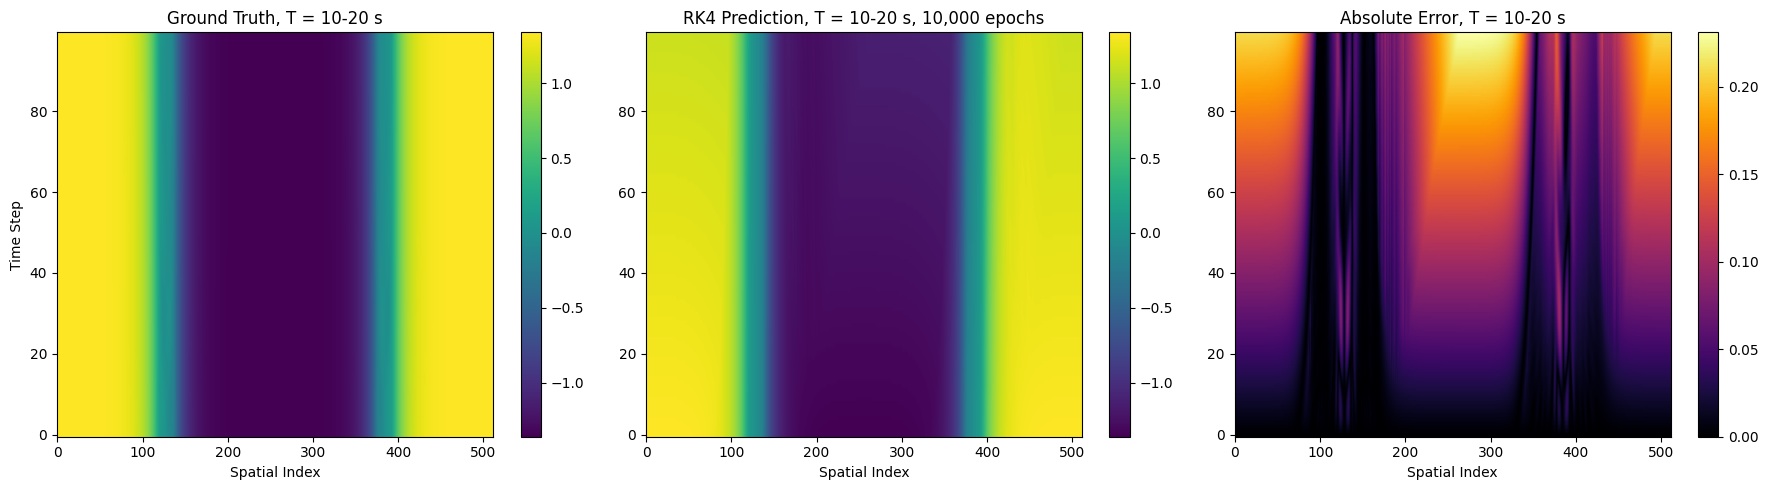

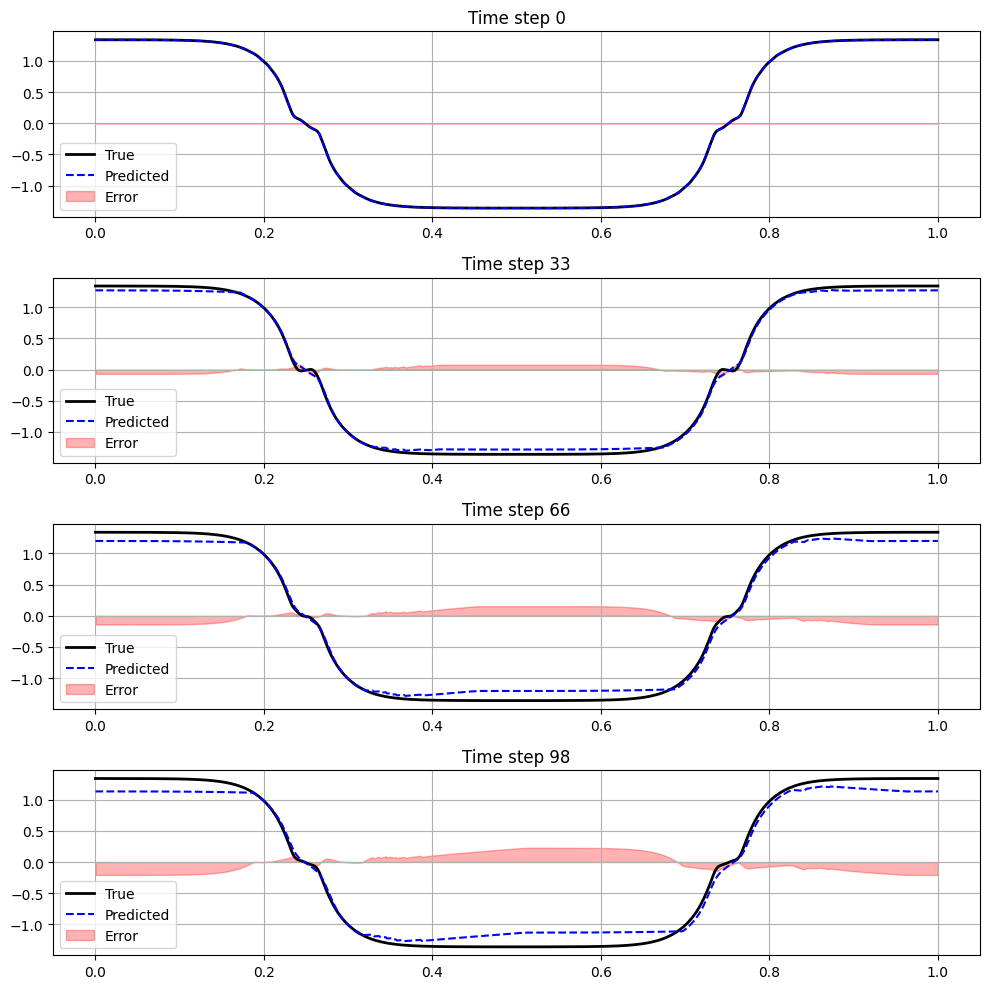

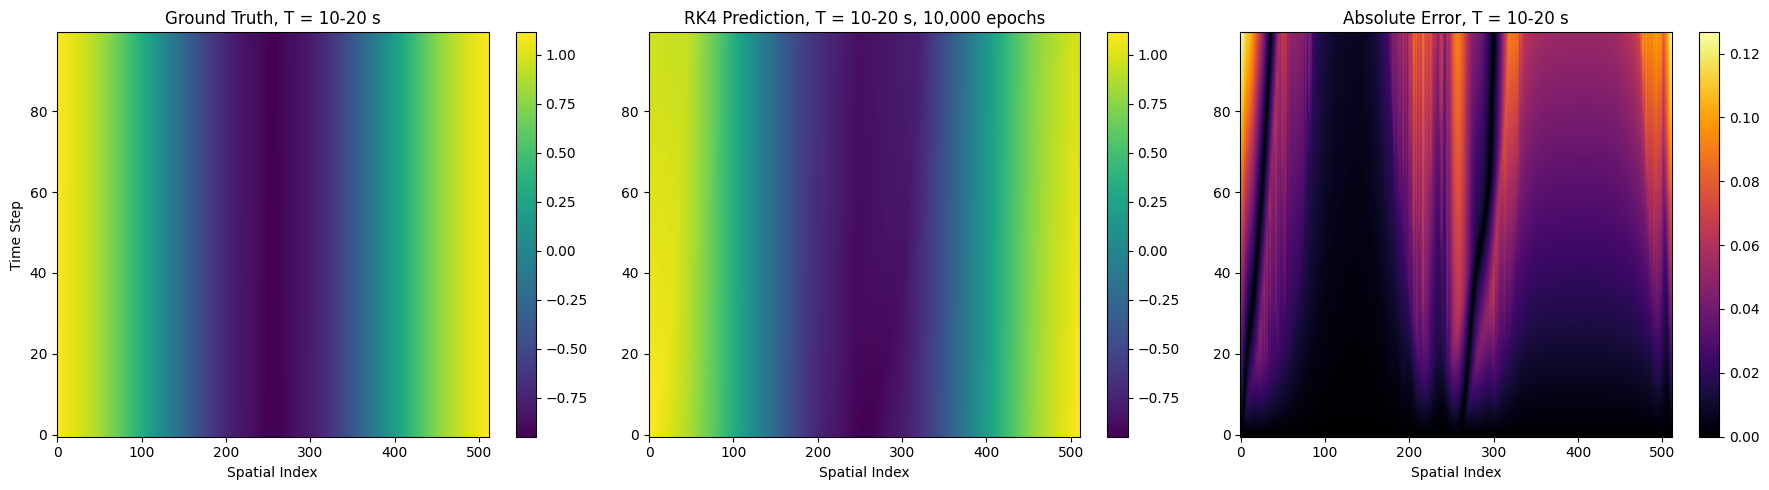

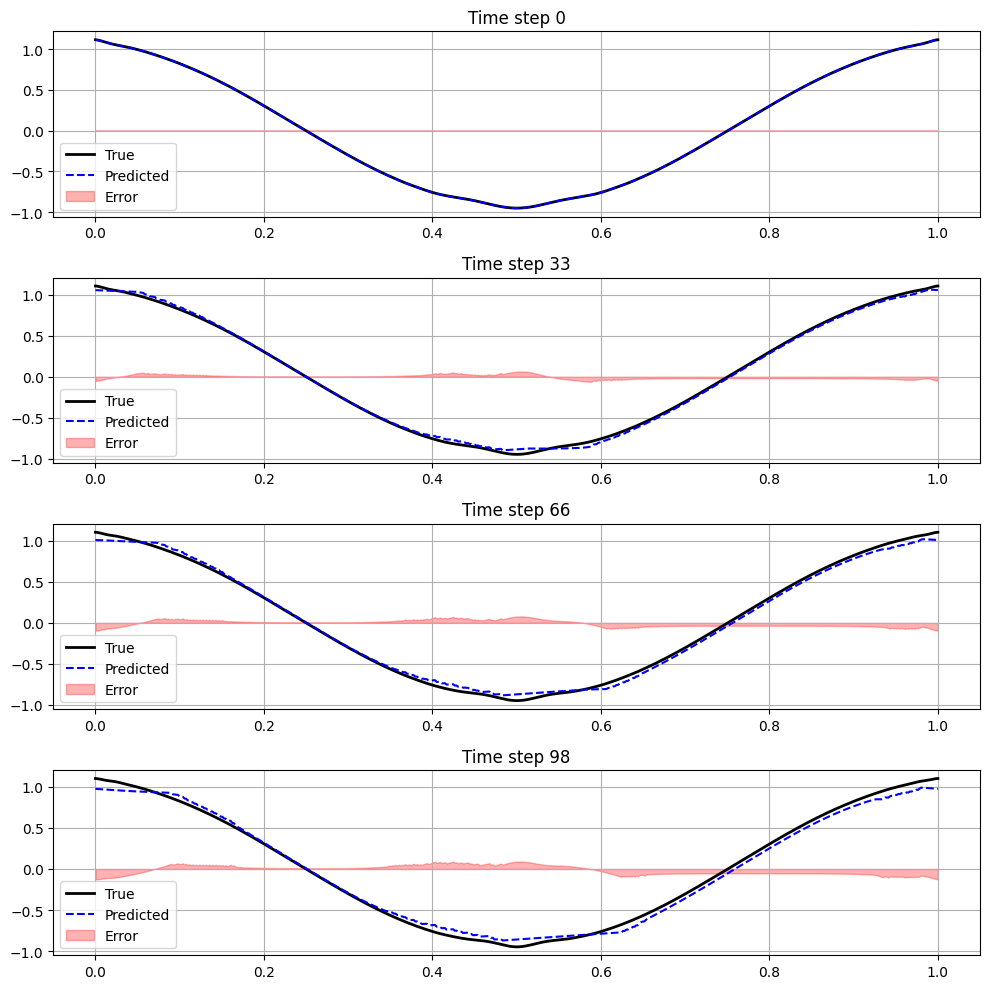

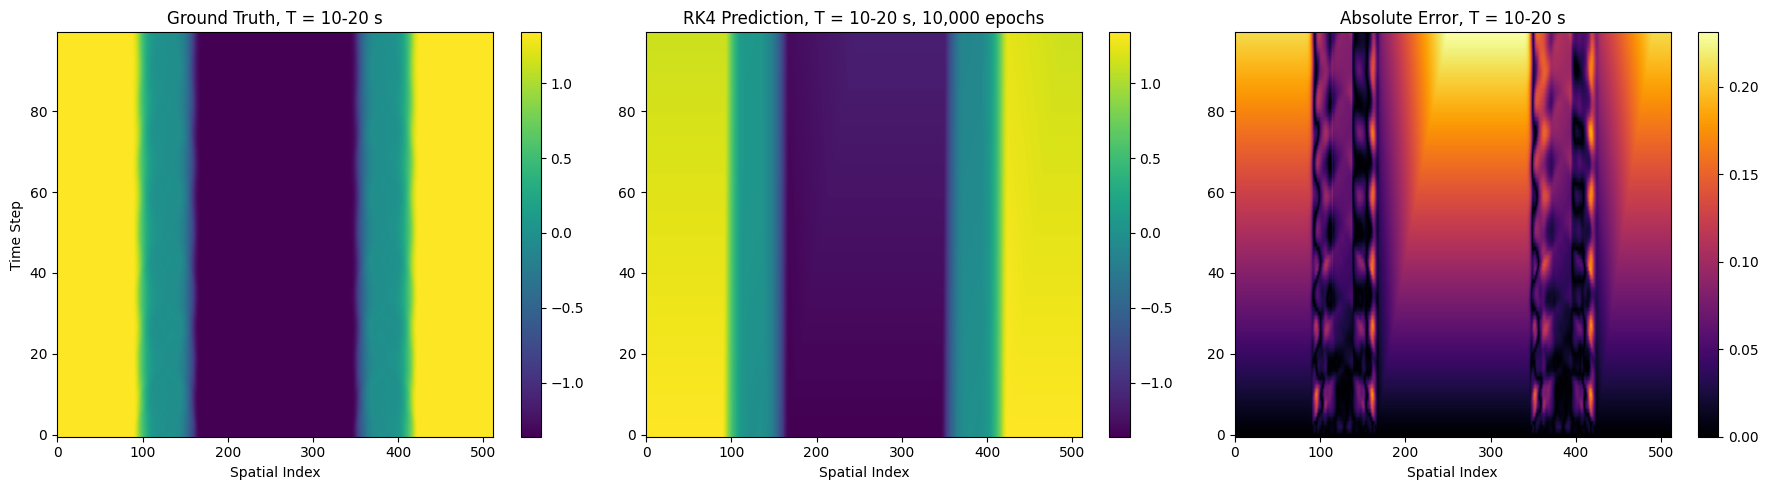

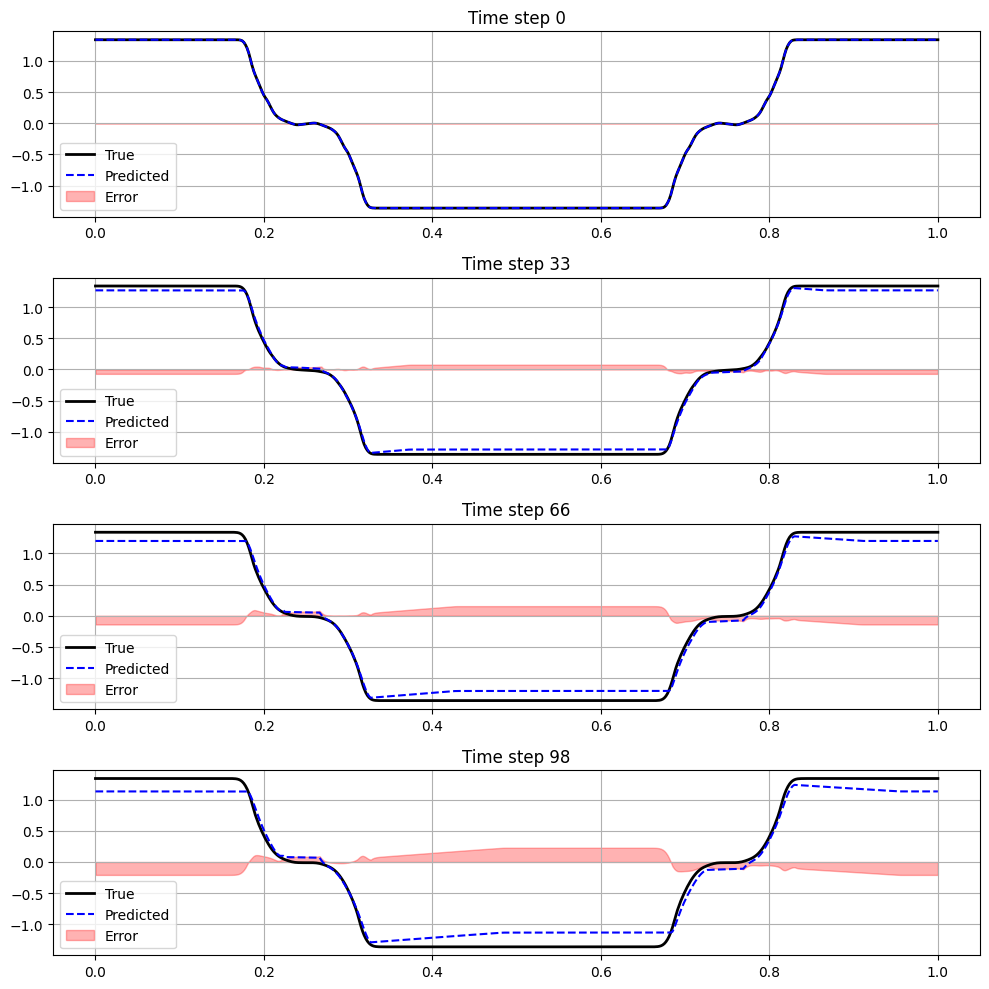

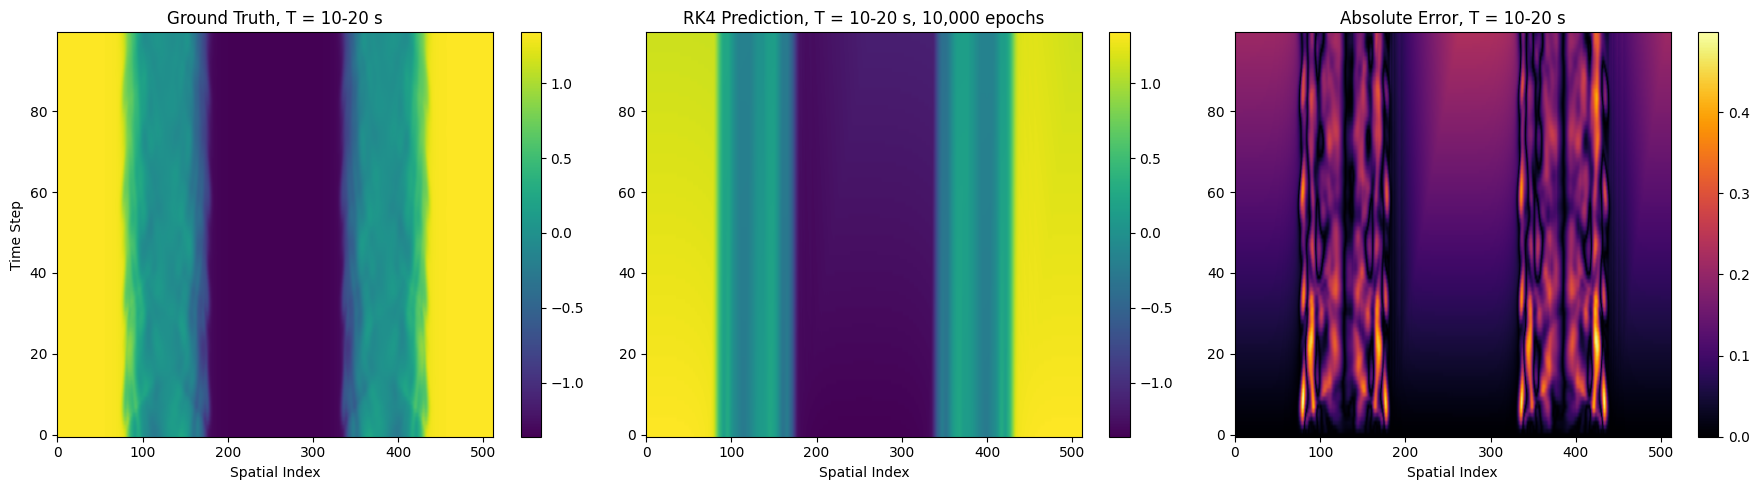

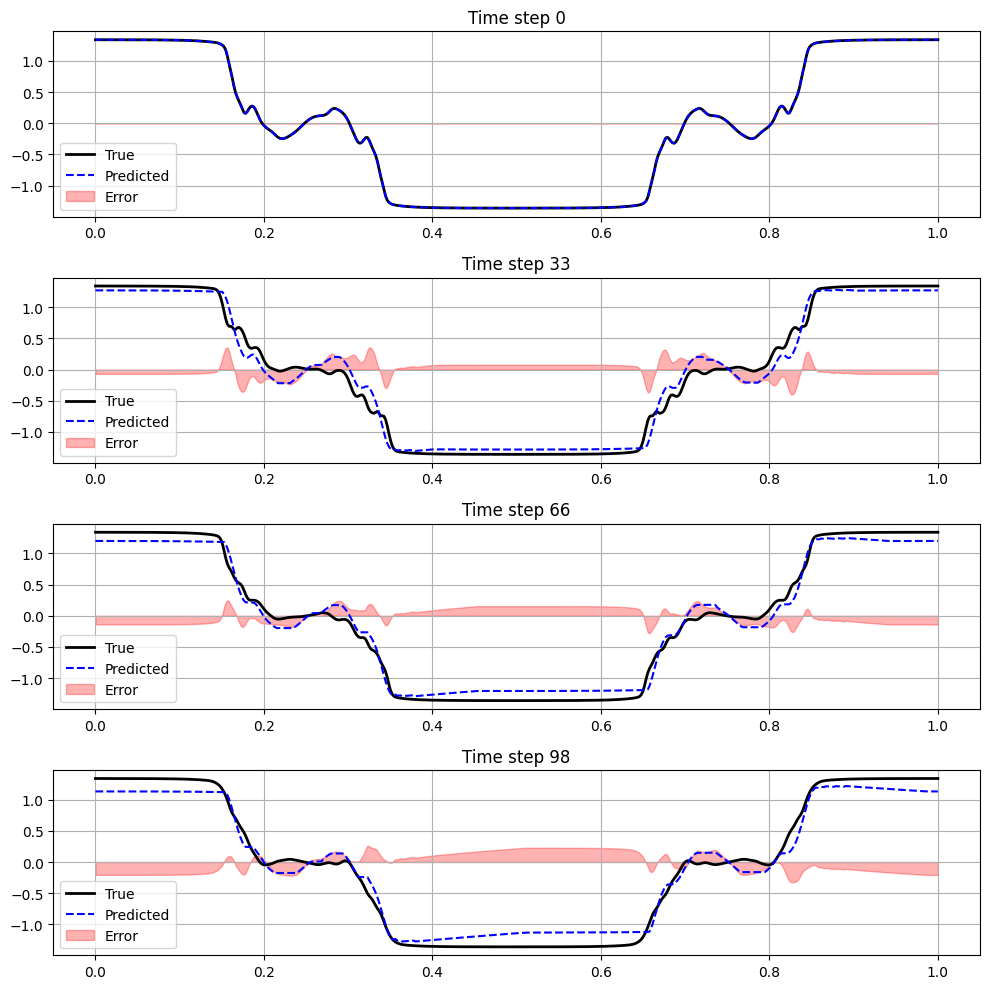

In [ ]:
for sample in range(4):
    # Get a sample from the test dataset
    test_input, test_target = test_dataset[sample]  # test_input: [1, T_input, X], test_target: [1, T_target, X]
    test_target = test_target.unsqueeze(0).to(device)  # Add batch dimension: [1, 1, T_input, X]
    test_target = test_target.squeeze(1)  # shape: [1, T_input, X]
    u0_test = test_target[:, 0, :].double()  # Initial condition: [1, X]
    num_steps_eval = 99 # Total number of integration steps

    rk_solver = RK4(diffusionOperator, advectionOperator, dt=dt).to(device)
    # Integrate using model
    with torch.no_grad():
        u_pred_test, _, _ = rk_solver(u0_test, steps=num_steps_eval)
        u_pred_test = u_pred_test.reshape(num_steps_eval + 1, -1).unsqueeze(0)  # shape: [1, T, X] # Reshape before removing initial condition

    u_true_test = test_target[:, :(num_steps_eval + 1), :]  # truncate to match prediction

    # Compute absolute error
    error = torch.abs(u_true_test - u_pred_test).squeeze(0).cpu()  # [T_total, X]

    # Convert to numpy for plotting
    u_pred_np = u_pred_test.squeeze(0).cpu().numpy()  # [T_total, X]
    u_true_np = u_true_test.squeeze(0).cpu().numpy()  # [T_total, X]
    error_np  = error.numpy()                         # [T_total, X]

    # Determine shared color map limits for true and predicted plots
    vmin = min(u_true_np.min(), u_pred_np.min())
    vmax = max(u_true_np.max(), u_pred_np.max())

    # === Plot results ===
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axs[0].imshow(u_true_np, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    axs[0].set_title("Ground Truth, T = 10-20 s")
    axs[0].set_xlabel("Spatial Index")
    axs[0].set_ylabel("Time Step")
    fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(u_pred_np, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1].set_title("RK4 Prediction, T = 10-20 s, 10,000 epochs")
    axs[1].set_xlabel("Spatial Index")
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(error_np, aspect='auto', origin='lower', cmap='inferno')
    axs[2].set_title("Absolute Error, T = 10-20 s")
    axs[2].set_xlabel("Spatial Index")
    fig.colorbar(im2, ax=axs[2])

    plt.tight_layout()
    plt.show()

    # Create x-axis for plotting
    x = torch.linspace(0, L, nx).cpu().numpy()

    # Call the function
    plot_prediction_vs_truth(u_pred_test, u_true_test, x_axis=x, num_steps_eval=num_steps_eval)

# FNO

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        self.scale = (1 / (in_channels * out_channels))
        # Initialize weights with complex<double> to match input dtype when model is .double()
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cdouble))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cdouble))

    def forward(self, x):
        # x shape: [batch_size, in_channels, spatial_size] -> e.g., [B, width, X]
        batchsize = x.shape[0]
        size_x = x.shape[-1]

        # Compute Fourier transform
        x_ft = torch.fft.rfft(x, dim=-1) # [B, in_channels, X // 2 + 1]

        # Multiply relevant modes
        # Ensure out_ft is also complex<double>
        out_ft = torch.zeros(batchsize, self.out_channels, size_x // 2 + 1, dtype=torch.cdouble, device=x.device)
        out_ft[:, :, :self.modes] = torch.einsum("bix,iox->box", x_ft[:, :, :self.modes], self.weights1)
        out_ft[:, :, -self.modes:] = torch.einsum("bix,iox->box", x_ft[:, :, -self.modes:], self.weights2)


        # Inverse Fourier transform
        x = torch.fft.irfft(out_ft, n=size_x, dim=-1)

        return x

class FNO(nn.Module):
    def __init__(self, modes, width, in_channels=1, out_channels=1, num_fourier_layers=4):
        super().__init__()
        self.modes = modes
        self.width = width
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_fourier_layers = num_fourier_layers

        # Input lifting
        self.fc0 = nn.Linear(in_channels, self.width)

        # Fourier layers
        self.fourier_layers = nn.ModuleList()
        for _ in range(self.num_fourier_layers):
            # Use the updated SpectralConv1d
            self.fourier_layers.append(SpectralConv1d(self.width, self.width, self.modes))
            self.fourier_layers.append(nn.Linear(self.width, self.width))

        # Output projection
        self.fc1 = nn.Linear(self.width, self.width)
        self.fc2 = nn.Linear(self.width, out_channels)

    def forward(self, x):
        # x shape: [batch_size, in_channels, spatial_size] -> e.g., [B, 1, X]

        # Lift input
        x = self.fc0(x.permute(0, 2, 1)).permute(0, 2, 1) # [B, width, X]

        # Apply Fourier layers
        for i in range(self.num_fourier_layers):
            spectral_conv = self.fourier_layers[2 * i]
            linear = self.fourier_layers[2 * i + 1]

            x = spectral_conv(x)
            # Ensure linear layer input and output match the spectral_conv output shape [B, width, X]
            x = x + linear(x.permute(0, 2, 1)).permute(0, 2, 1) # Add linear layer output
            x = F.gelu(x) # Activation

        # Project output
        x = self.fc1(x.permute(0, 2, 1)).permute(0, 2, 1) # [B, width, X]
        x = F.gelu(x)
        x = self.fc2(x.permute(0, 2, 1)).permute(0, 2, 1) # [B, out_channels, X]

        return x

In [ ]:
import torch
import torch.optim as optim
from torch import nn
import os
import matplotlib.pyplot as plt

# FNO and SpectralConv1d classes should be defined above this cell

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = './FNO_Model' # New save directory for FNO

# Create the save directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Constants (ensure these match your data and problem setup)
L = 1.0
nx = 512
dx = L / (nx - 1)
dt = 0.01
nt = 199
D = 1 / (5e5 * 2e-1) # Example diffusion coefficient
num_steps_eval = 99 # Number of steps to evaluate over

# FNO specific parameters
modes = 16
width = 32
num_epochs = 10001 # Number of training epochs

# Load batch
# Assuming train_loader is already defined and contains the training data
train_batch = next(iter(train_loader))
inputs, targets = train_batch
inputs = inputs.to(device).double()
targets = targets.to(device).double()

# Concatenate inputs and targets along the time dimension to get the full sequence
full_sequence = torch.cat((inputs.squeeze(1), targets.squeeze(1)), dim=1) # [B, T_total, X]

# Initialize FNO model
fno_model = FNO(modes=modes, width=width, in_channels=1, out_channels=1, num_fourier_layers=4).to(device).double()

# Modify the optimizer to optimize FNO parameters
optimizer = optim.Adam(fno_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Function to compute spatial loss with boundary weighting
def compute_spatial_loss_with_boundary(u_pred, u_target, boundary_weight=5.0, boundary_width=32):
    # u_pred and u_target shapes are [B, 1, X] in this (u_t, u_{t+1}) training loop
    # Adjust unpacking to match the actual shape
    B, T, X = u_pred.shape # T will be 1 in this case

    weights = torch.ones((1, 1, X), dtype=u_pred.dtype, device=u_pred.device)
    weights[..., :boundary_width] *= boundary_weight
    weights[..., -boundary_width:] *= boundary_weight

    # Apply weights across spatial dimension
    weighted_error_sq = weights * (u_pred - u_target) ** 2
    spatial_loss = torch.mean(weighted_error_sq)

    return spatial_loss


# ======================
# Training loop
# =====================

T_total_data = full_sequence.shape[1]
# We will train the FNO to predict u_{t+1} from u_t for all available time steps
num_time_steps_to_train = T_total_data - 1

for epoch in range(num_epochs):
    fno_model.train()
    optimizer.zero_grad()

    total_loss = 0

    # Iterate through all time steps to create (u_t, u_{t+1}) pairs
    for t in range(num_time_steps_to_train):
        # u_t shape: [B, X], unsqueeze to [B, 1, X] for FNO input (in_channels=1)
        u_t = full_sequence[:, t, :].unsqueeze(1).clone().detach().requires_grad_(True)
        # u_t_plus_1_target shape: [B, X], unsqueeze to [B, 1, X] for loss calculation
        u_t_plus_1_target = full_sequence[:, t + 1, :].unsqueeze(1).clone().detach()

        # Forward pass: Predict u_{t+1} from u_t
        u_t_plus_1_pred = fno_model(u_t) # [B, 1, X]

        # Compute loss for this time step
        loss_t = compute_spatial_loss_with_boundary(
            u_t_plus_1_pred, # [B, 1, X]
            u_t_plus_1_target, # [B, 1, X]
            boundary_weight=5.0,
            boundary_width=32
        )
        total_loss += loss_t

    # Average the loss over time steps
    loss = total_loss / num_time_steps_to_train

    loss.backward()

    # === Gradient Clipping ===
    torch.nn.utils.clip_grad_norm_(fno_model.parameters(), max_norm=1.0)

    optimizer.step()

    # Print diagnostics
    if epoch % 1 == 0:
        # ===== Gradient norm logging (for FNO parameters) =====
        total_norm = 0.0
        for p in fno_model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        print(f"Epoch {epoch}: Grad norm = {total_norm:.4e}")
        # ======================================================
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4e}")

    # Save FNO model state dictionary
    if epoch % 10 == 0:
        torch.save(fno_model.state_dict(), os.path.join(save_dir, f"fno_model_epoch_{epoch}.pth"))
        print(f"Saved FNO model at epoch {epoch} to {save_dir}")

# Note: Evaluation and plotting code will need to be adapted separately to use the trained FNO model
# for autoregressive prediction over multiple time steps.

Epoch 0: Grad norm = 1.0000e+00
Epoch 0/10001, Loss: 1.5798e+00
Saved FNO model at epoch 0 to /content/drive/MyDrive/Thesis/FNO_Model
Epoch 1: Grad norm = 1.0000e+00
Epoch 1/10001, Loss: 1.5790e+00
Epoch 2: Grad norm = 1.0000e+00
Epoch 2/10001, Loss: 1.5782e+00
Epoch 3: Grad norm = 1.0000e+00
Epoch 3/10001, Loss: 1.5774e+00
Epoch 4: Grad norm = 1.0000e+00
Epoch 4/10001, Loss: 1.5765e+00
Epoch 5: Grad norm = 1.0000e+00
Epoch 5/10001, Loss: 1.5757e+00
Epoch 6: Grad norm = 1.0000e+00
Epoch 6/10001, Loss: 1.5749e+00
Epoch 7: Grad norm = 1.0000e+00
Epoch 7/10001, Loss: 1.5741e+00
Epoch 8: Grad norm = 1.0000e+00
Epoch 8/10001, Loss: 1.5733e+00
Epoch 9: Grad norm = 1.0000e+00
Epoch 9/10001, Loss: 1.5725e+00
Epoch 10: Grad norm = 1.0000e+00
Epoch 10/10001, Loss: 1.5716e+00
Saved FNO model at epoch 10 to /content/drive/MyDrive/Thesis/FNO_Model
Epoch 11: Grad norm = 1.0000e+00
Epoch 11/10001, Loss: 1.5708e+00
Epoch 12: Grad norm = 1.0000e+00
Epoch 12/10001, Loss: 1.5700e+00
Epoch 13: Grad norm =

KeyboardInterrupt: 

FNO: 31m for 150 epochs - 13h 46m for 4000 epochs

Loaded FNO model from /content/drive/MyDrive/Thesis/FNO_Model/fno_model_epoch_200.pth


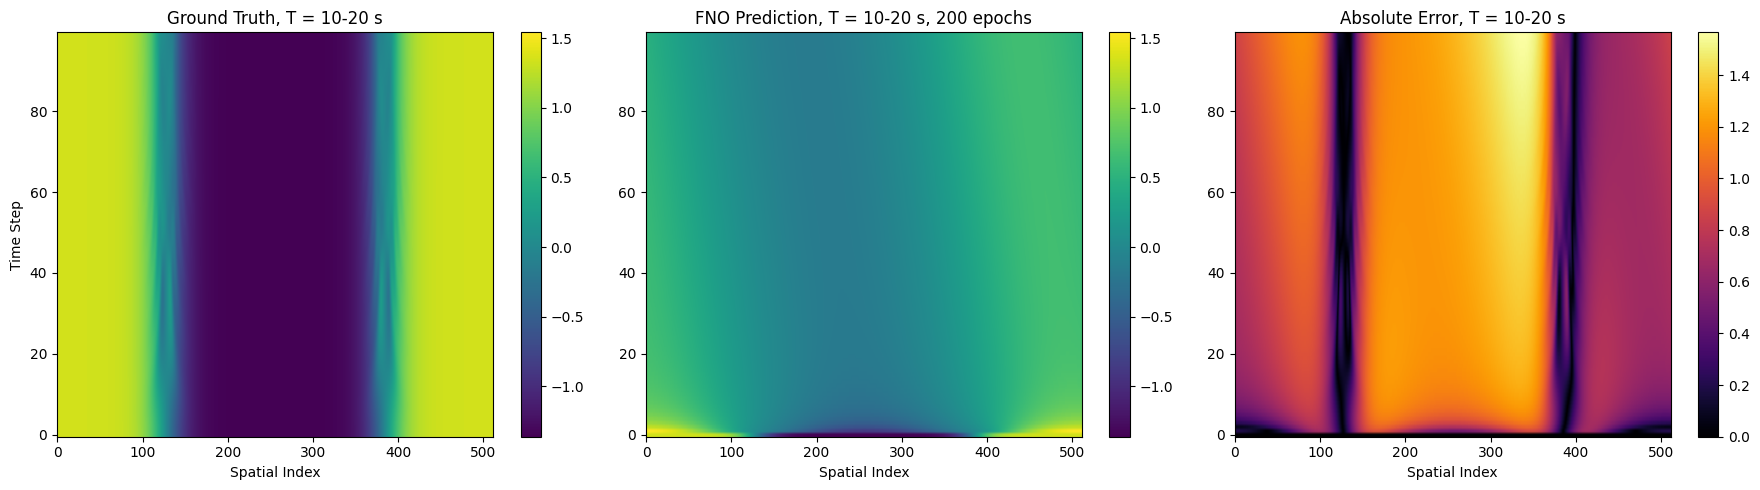

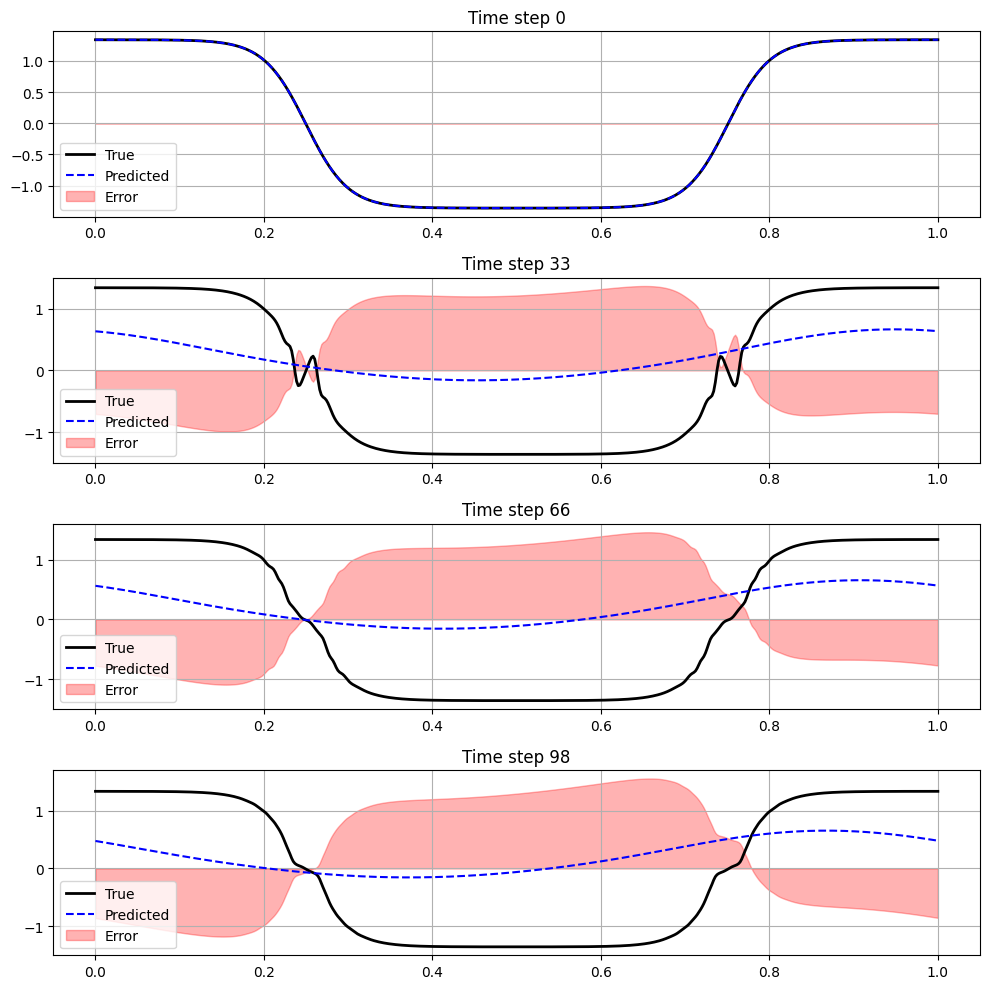

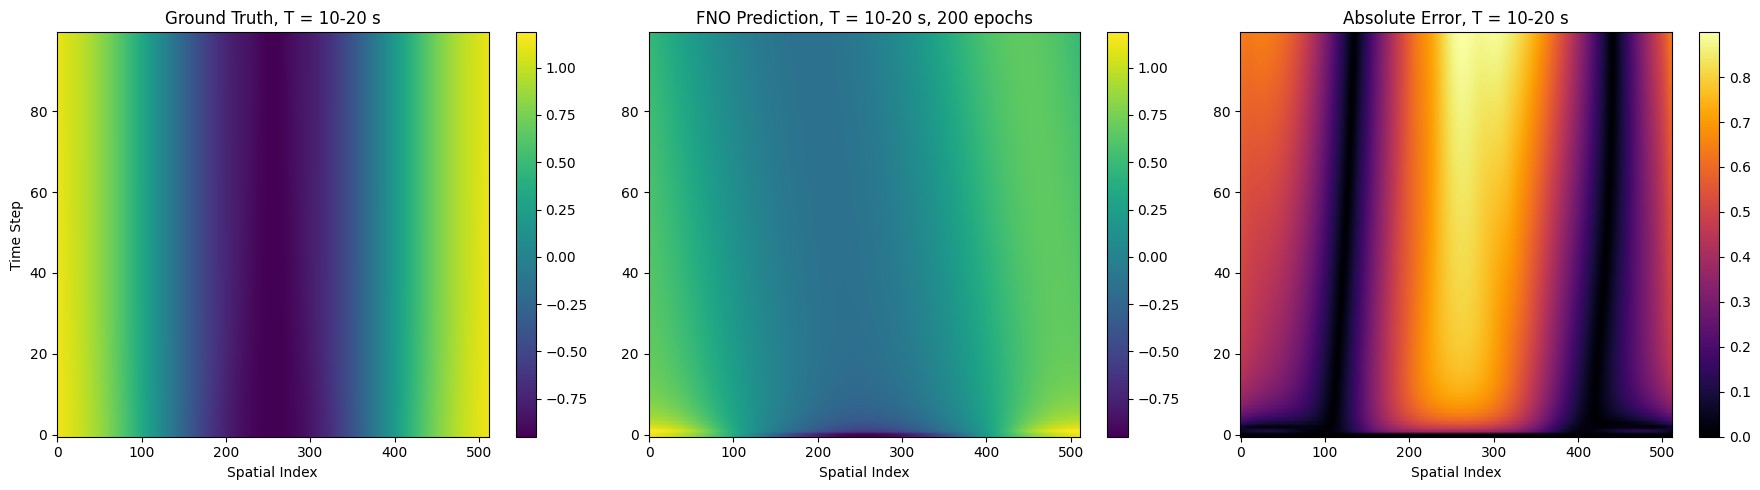

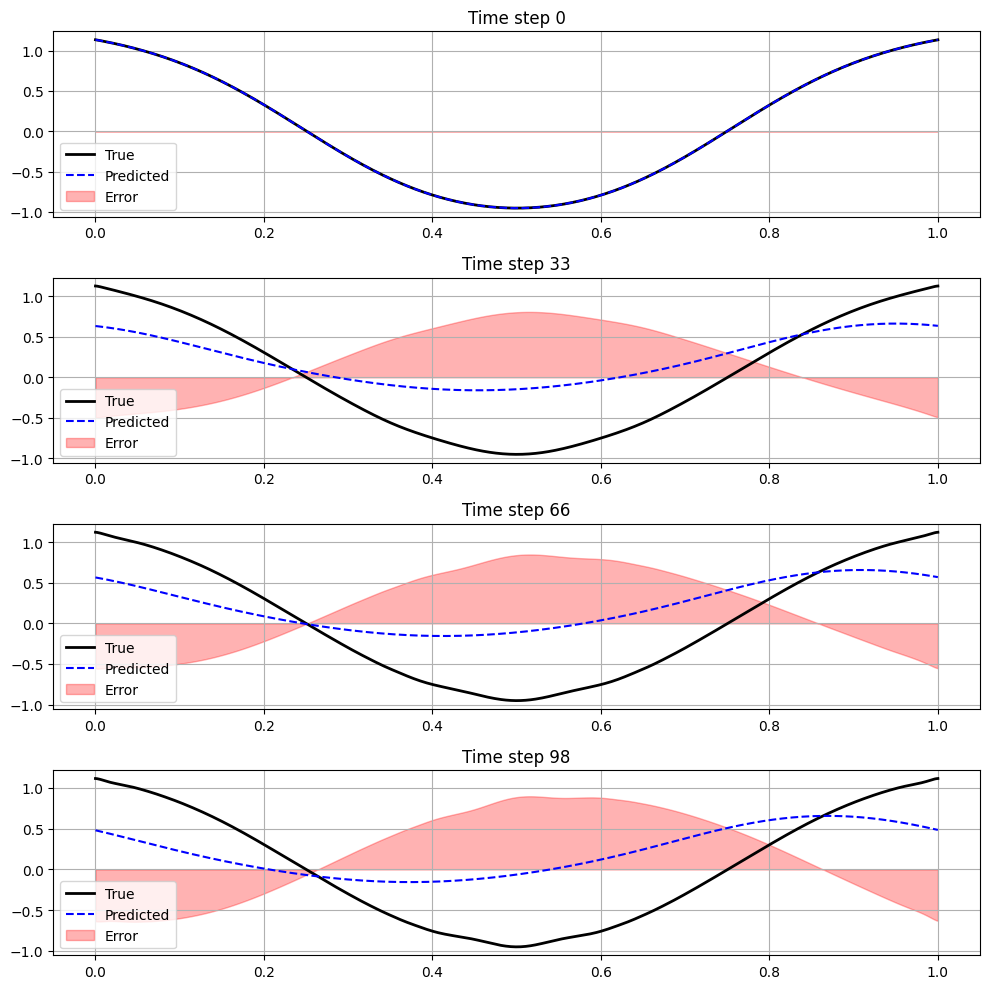

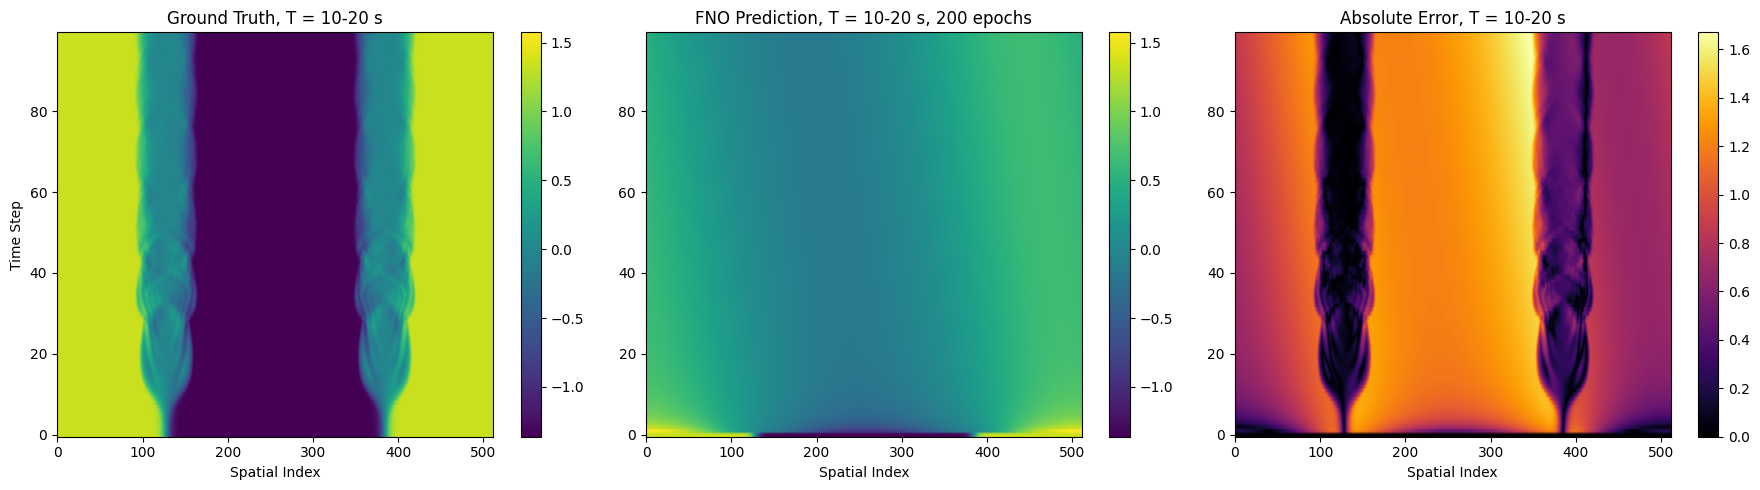

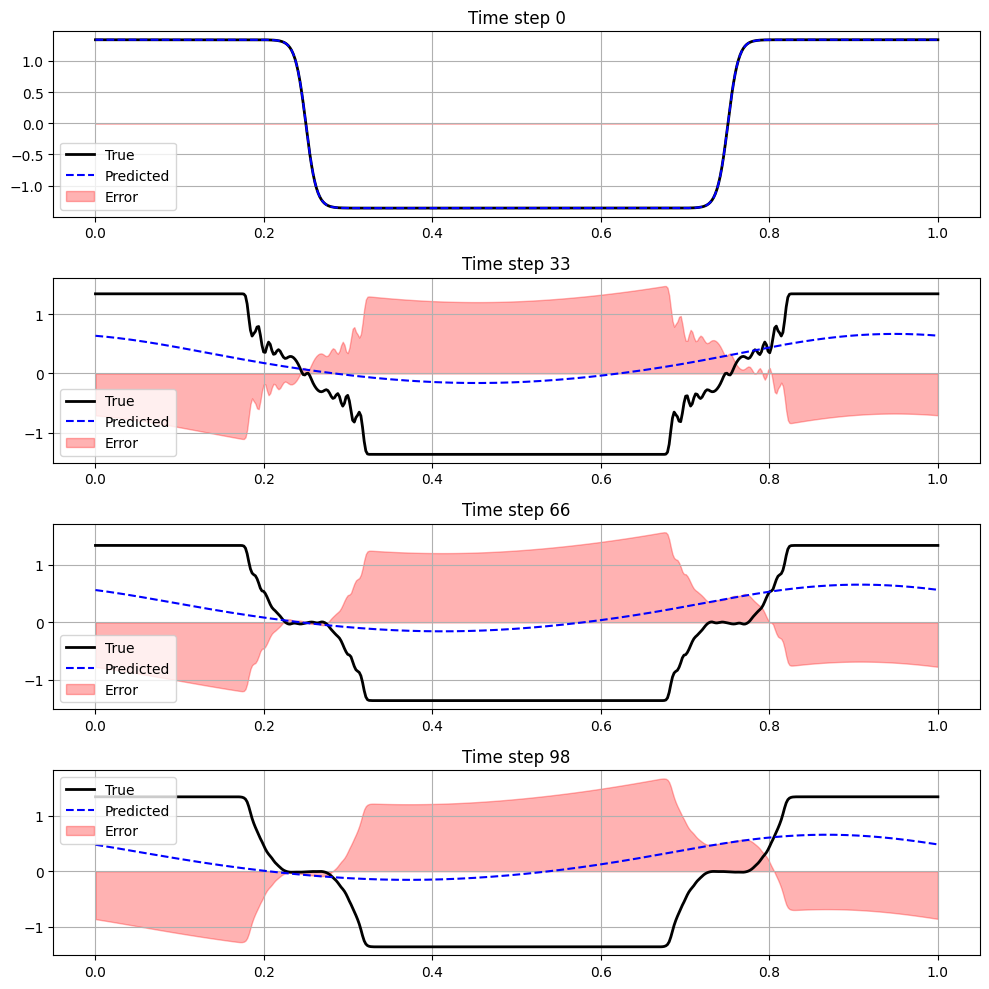

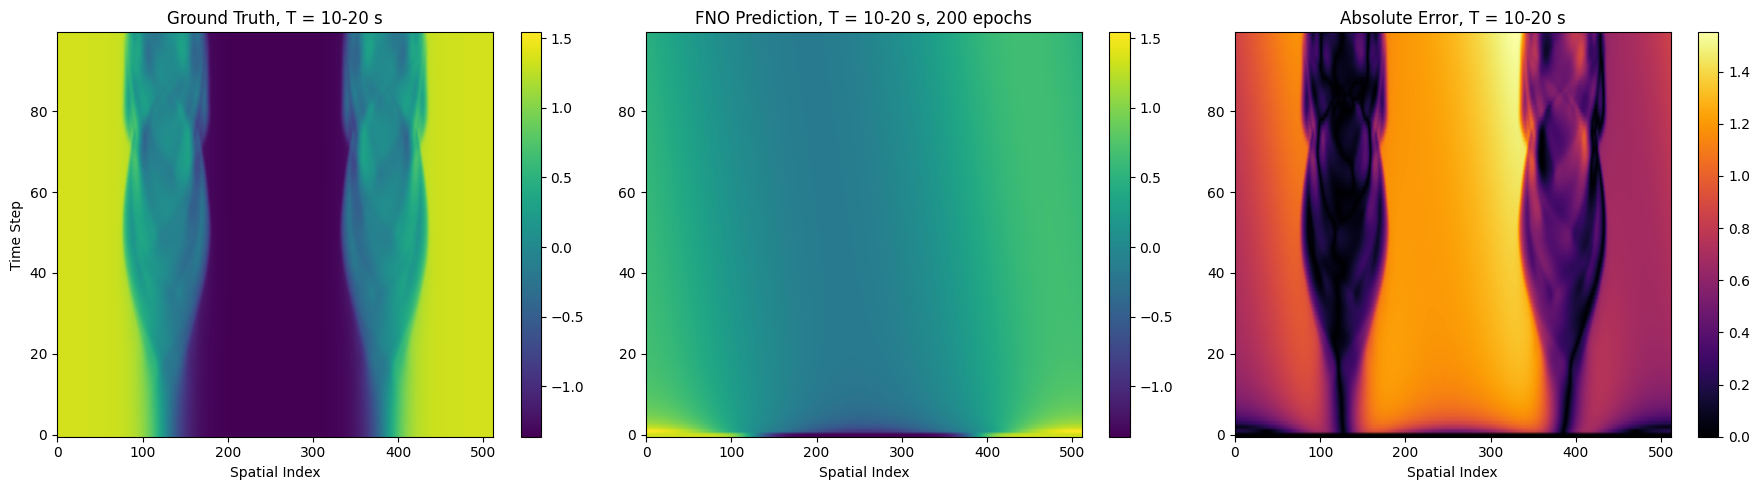

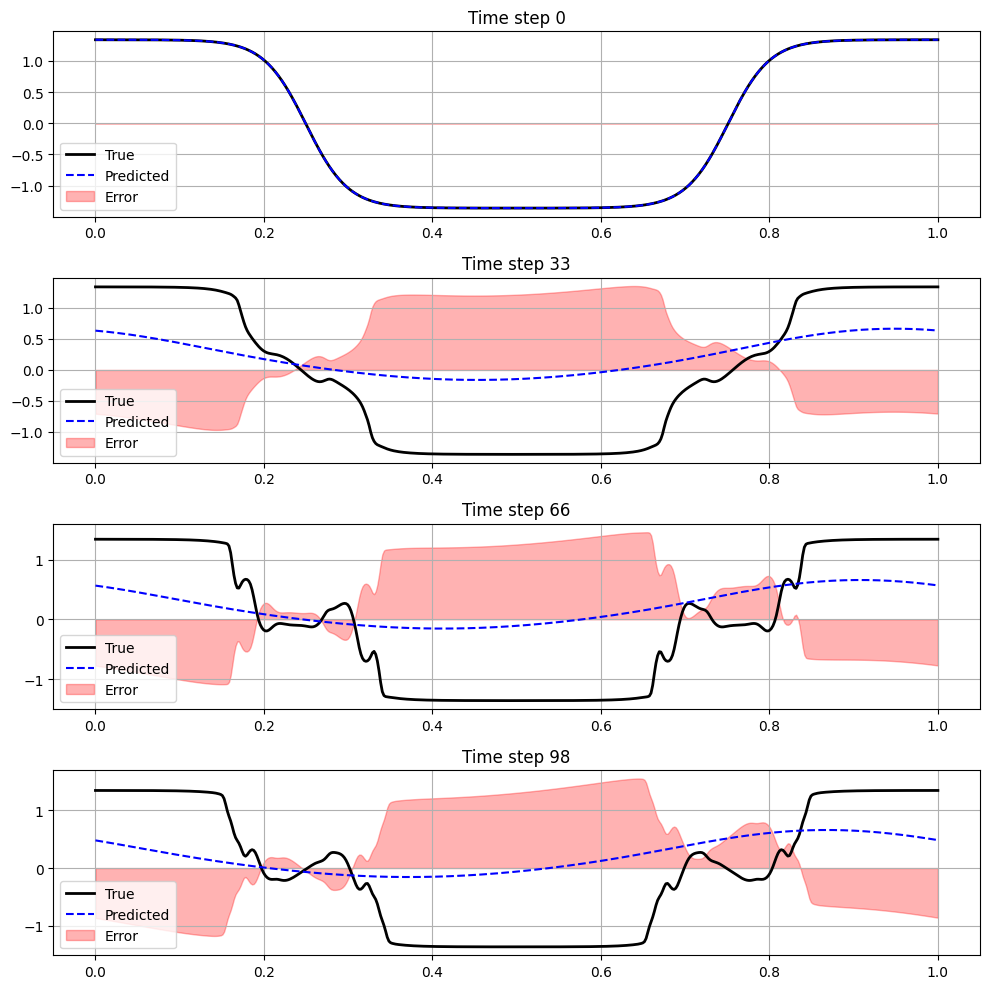

In [ ]:
# Paths
save_dir = './FNO_Model' # Save directory for FNO
# Choose the epoch to load based on your training progress
epoch_to_load = 200

# FNO specific parameters (should match the trained model)
modes = 16
width = 32
num_steps_eval = 99 # Number of steps to evaluate over

# Initialize FNO model and load trained weights
fno_model = FNO(modes=modes, width=width, in_channels=1, out_channels=1, num_fourier_layers=4).to(device).double()
model_path = os.path.join(save_dir, f'fno_model_epoch_{epoch_to_load}.pth')

# Check if the model file exists before loading
if os.path.exists(model_path):
    fno_model.load_state_dict(torch.load(model_path))
    print(f"Loaded FNO model from {model_path}")
else:
    print(f"Model file not found at {model_path}. Please ensure the correct epoch is specified and the file exists.")
    # Optionally, exit or handle the error as needed
    # For now, we will continue with the initialized model (not trained)


# Set to eval mode
fno_model.eval()

for sample in range(4):
    # Get a sample from the test dataset
    # Assuming test_dataset is already defined and contains the test data
    test_input, test_target = test_dataset[sample]  # test_input: [1, T_input, X], test_target: [1, T_target, X]

    # Concatenate test input and target to get the full test sequence for evaluation
    full_test_sequence = torch.cat((test_input.squeeze(1), test_target.squeeze(1)), dim=1) # [1, T_total_test, X]

    # Set the initial condition for autoregressive prediction
    # Use the first time step from the test sequence
    u0_test = full_test_sequence[:, 0, :].unsqueeze(1).to(device).double() # Shape: [1, 1, X]

    # Perform autoregressive prediction using the FNO model
    u_pred_list = [u0_test.squeeze(1)] # Start with the initial condition [1, X]

    with torch.no_grad():
        current_u = u0_test
        for t in range(num_steps_eval):
            # Predict the next time step
            next_u = fno_model(current_u) # [1, 1, X]
            u_pred_list.append(next_u.squeeze(1)) # Append [1, X] to list
            current_u = next_u # Set the prediction as the input for the next step

    # Concatenate the predicted time steps
    u_pred_test = torch.stack(u_pred_list, dim=1) # Shape: [1, num_steps_eval + 1, X]

    # Get the corresponding ground truth sequence for comparison
    u_true_test = full_test_sequence[:, :(num_steps_eval + 1), :] # Shape: [1, num_steps_eval + 1, X]

    # Compute absolute error
    error = torch.abs(u_true_test - u_pred_test).squeeze(0).cpu()  # [T_total, X]

    # Convert to numpy for plotting
    u_pred_np = u_pred_test.squeeze(0).cpu().numpy()  # [T_total, X]
    u_true_np = u_true_test.squeeze(0).cpu().numpy()  # [T_total, X]
    error_np  = error.numpy()                         # [T_total, X]

    # Determine shared color map limits for true and predicted plots
    vmin = min(u_true_np.min(), u_pred_np.min())
    vmax = max(u_true_np.max(), u_pred_np.max())

    # === Plot results ===
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axs[0].imshow(u_true_np, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    axs[0].set_title("Ground Truth, T = 10-20 s") # Adjust title based on your data's time range
    axs[0].set_xlabel("Spatial Index")
    axs[0].set_ylabel("Time Step")
    fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(u_pred_np, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1].set_title(f"FNO Prediction, T = 10-20 s, {epoch_to_load} epochs") # Adjust title
    axs[1].set_xlabel("Spatial Index")
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(error_np, aspect='auto', origin='lower', cmap='inferno')
    axs[2].set_title("Absolute Error, T = 10-20 s") # Adjust title
    axs[2].set_xlabel("Spatial Index")
    fig.colorbar(im2, ax=axs[2])

    plt.tight_layout()
    plt.show()

    # Create x-axis for plotting
    x = torch.linspace(0, L, nx).cpu().numpy()

    # Function to plot snapshots at specific time steps
    def plot_prediction_vs_truth_snapshots(u_pred, u_target, x_axis, num_steps_eval, batch_id=0):
        # Select a few time steps to plot snapshots
        time_steps_to_plot = [0, (num_steps_eval//3), (2*num_steps_eval//3), num_steps_eval-1] # Include the last step

        fig, axs = plt.subplots(len(time_steps_to_plot), 1, figsize=(10, 2.5 * len(time_steps_to_plot)))
        if len(time_steps_to_plot) == 1:
            axs = [axs]

        for i, t in enumerate(time_steps_to_plot):
            pred = u_pred[batch_id, t].detach().cpu().numpy()
            truth = u_target[batch_id, t].detach().cpu().numpy()
            error = pred - truth

            axs[i].plot(x_axis, truth, label="True", color='black', linewidth=2)
            axs[i].plot(x_axis, pred, label="Predicted", color='blue', linestyle='--')
            axs[i].fill_between(x_axis, error, 0, color='red', alpha=0.3, label='Error')

            axs[i].set_title(f"Time step {t}")
            axs[i].legend()
            axs[i].grid(True)

        plt.tight_layout()
        plt.show()

    # Call the snapshot plotting function
    plot_prediction_vs_truth_snapshots(u_pred_test, u_true_test, x_axis=x, num_steps_eval=num_steps_eval)

Loaded Structured NN model
Loaded FNO model


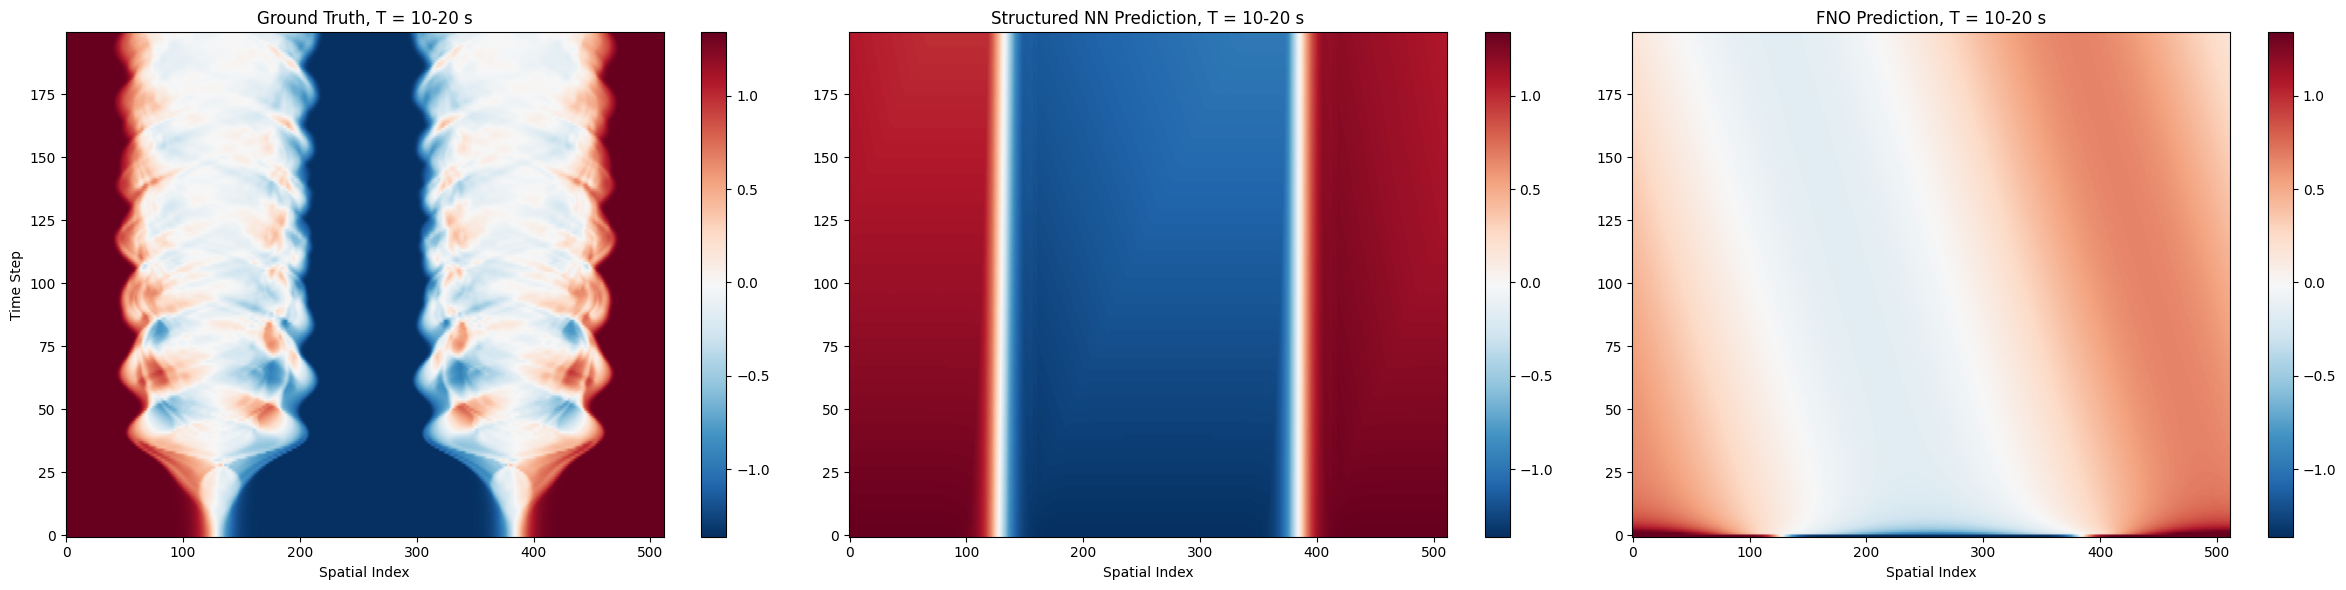

Sample 0, Time step 0:
  Average Absolute Error (Structured NN): 0.0000e+00
  Average Absolute Error (FNO): 0.0000e+00
Sample 0, Time step 66:
  Average Absolute Error (Structured NN): 4.9396e-01
  Average Absolute Error (FNO): 6.0552e-01
Sample 0, Time step 132:
  Average Absolute Error (Structured NN): 6.4591e-01
  Average Absolute Error (FNO): 6.8696e-01
Sample 0, Time step 199:
  Average Absolute Error (Structured NN): 5.9560e-01
  Average Absolute Error (FNO): 7.7224e-01


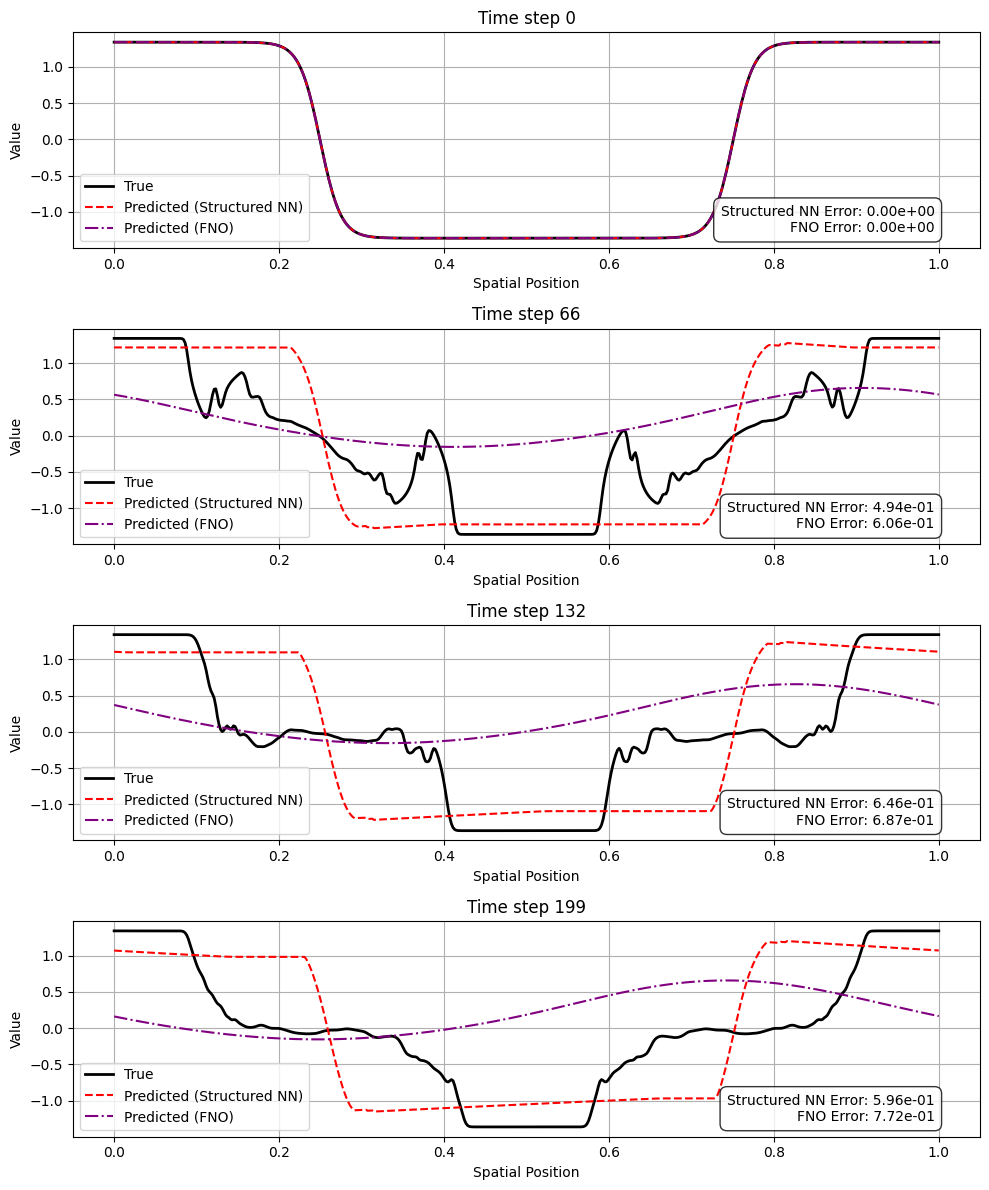

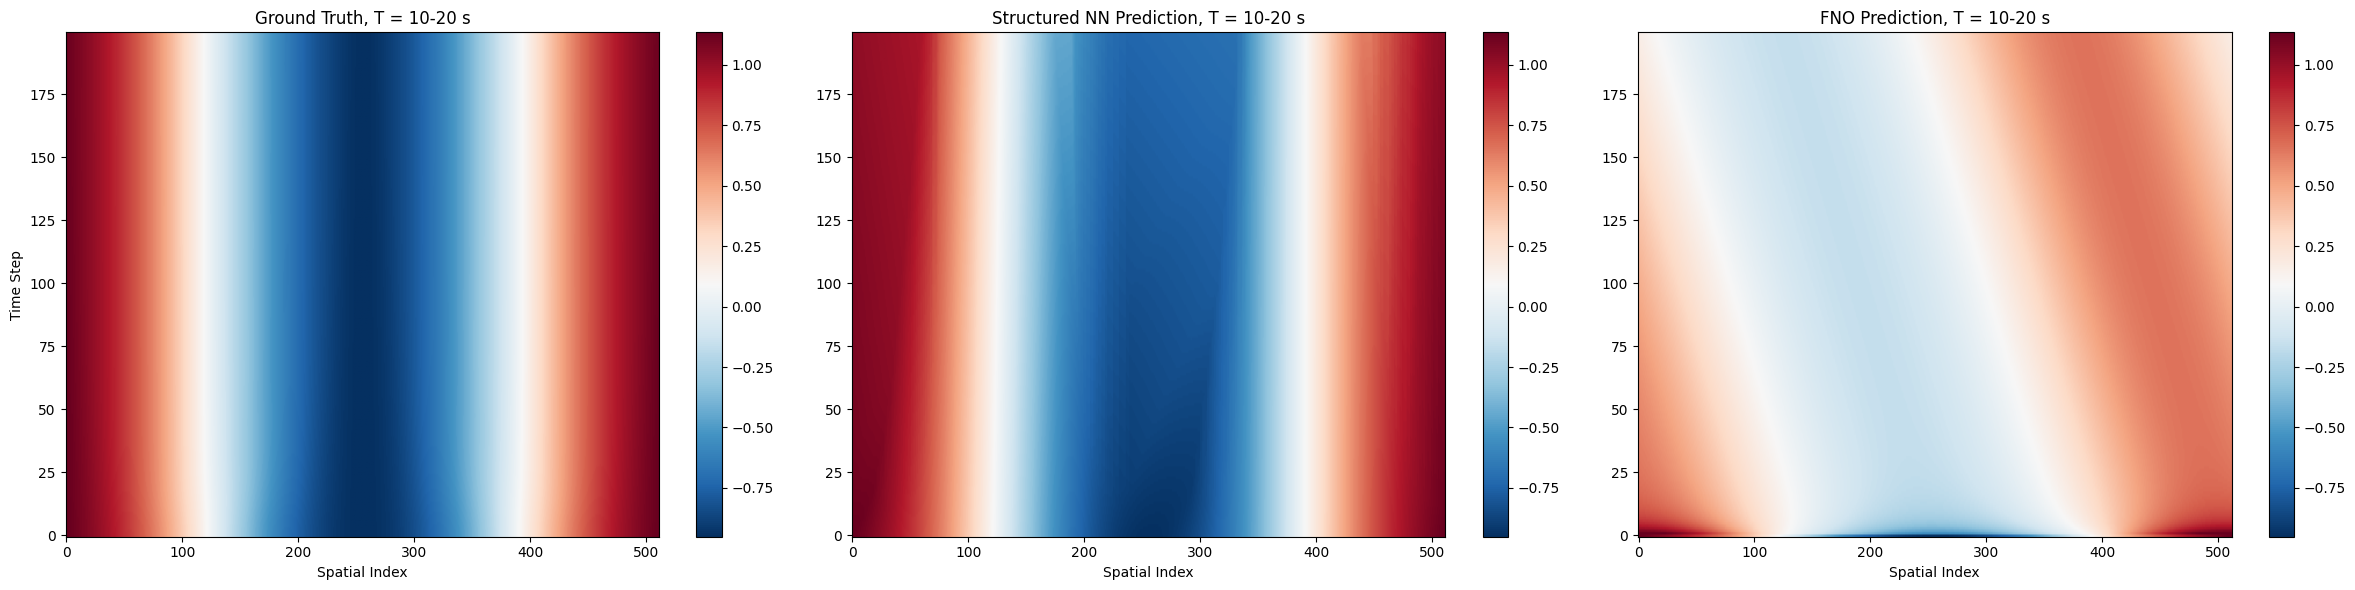

Sample 0, Time step 0:
  Average Absolute Error (Structured NN): 0.0000e+00
  Average Absolute Error (FNO): 0.0000e+00
Sample 0, Time step 66:
  Average Absolute Error (Structured NN): 4.3345e-02
  Average Absolute Error (FNO): 4.5533e-01
Sample 0, Time step 132:
  Average Absolute Error (Structured NN): 6.6929e-02
  Average Absolute Error (FNO): 5.7293e-01
Sample 0, Time step 199:
  Average Absolute Error (Structured NN): 9.4233e-02
  Average Absolute Error (FNO): 6.9733e-01


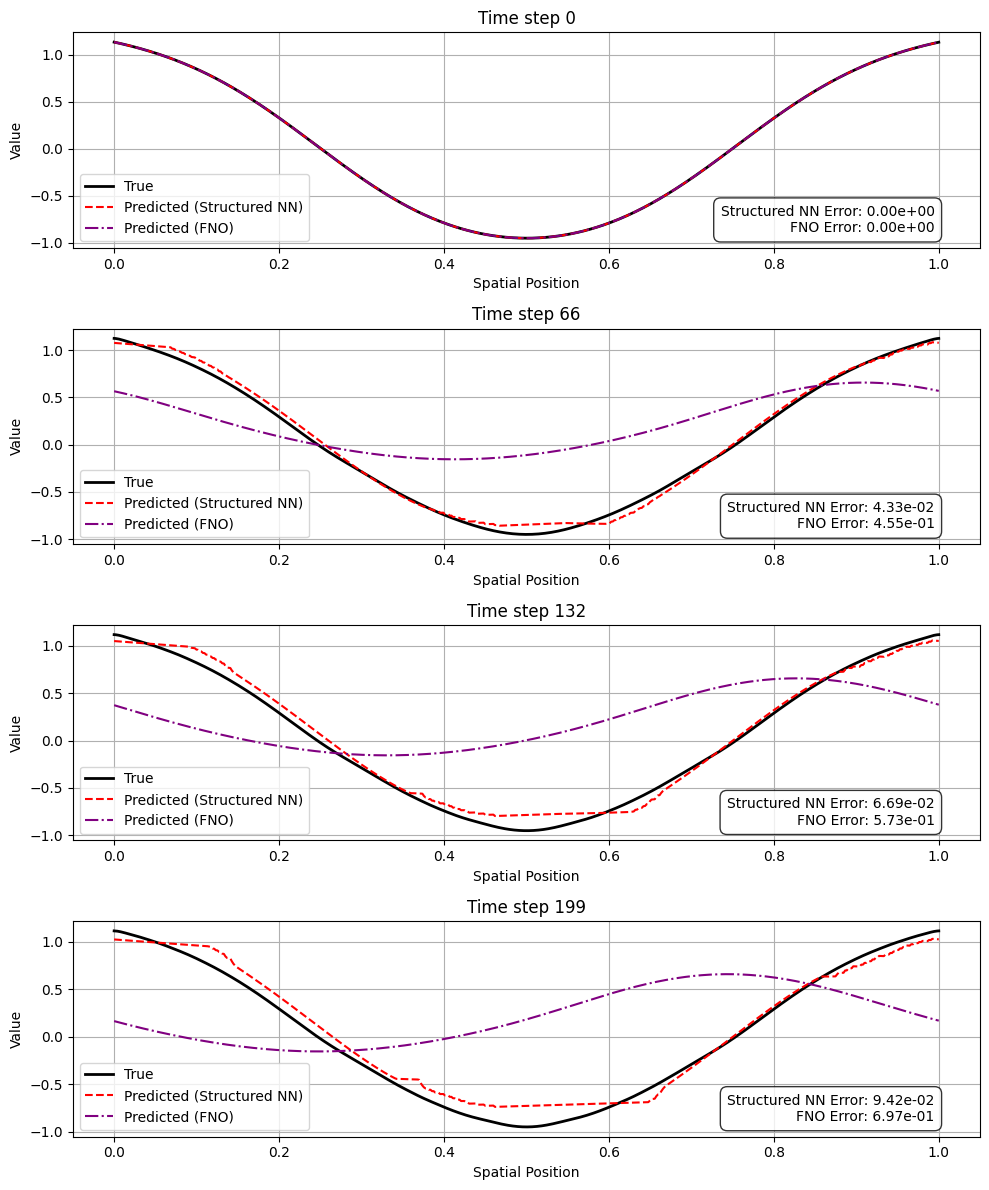

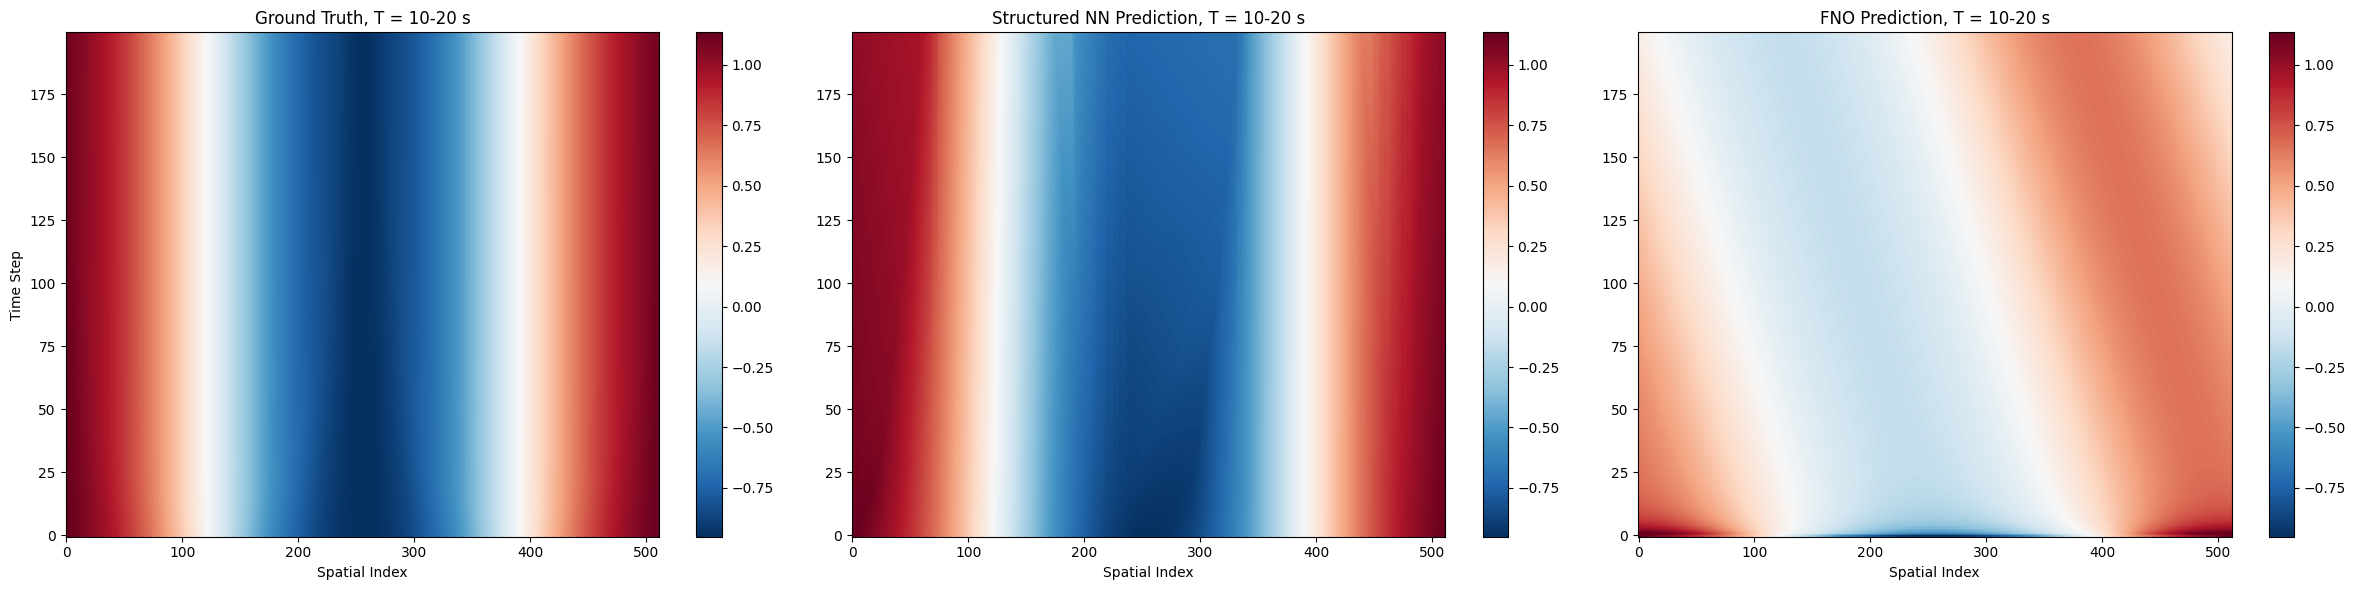

Sample 0, Time step 0:
  Average Absolute Error (Structured NN): 0.0000e+00
  Average Absolute Error (FNO): 0.0000e+00
Sample 0, Time step 66:
  Average Absolute Error (Structured NN): 3.6670e-02
  Average Absolute Error (FNO): 4.5455e-01
Sample 0, Time step 132:
  Average Absolute Error (Structured NN): 6.0202e-02
  Average Absolute Error (FNO): 5.7313e-01
Sample 0, Time step 199:
  Average Absolute Error (Structured NN): 8.7964e-02
  Average Absolute Error (FNO): 6.9783e-01


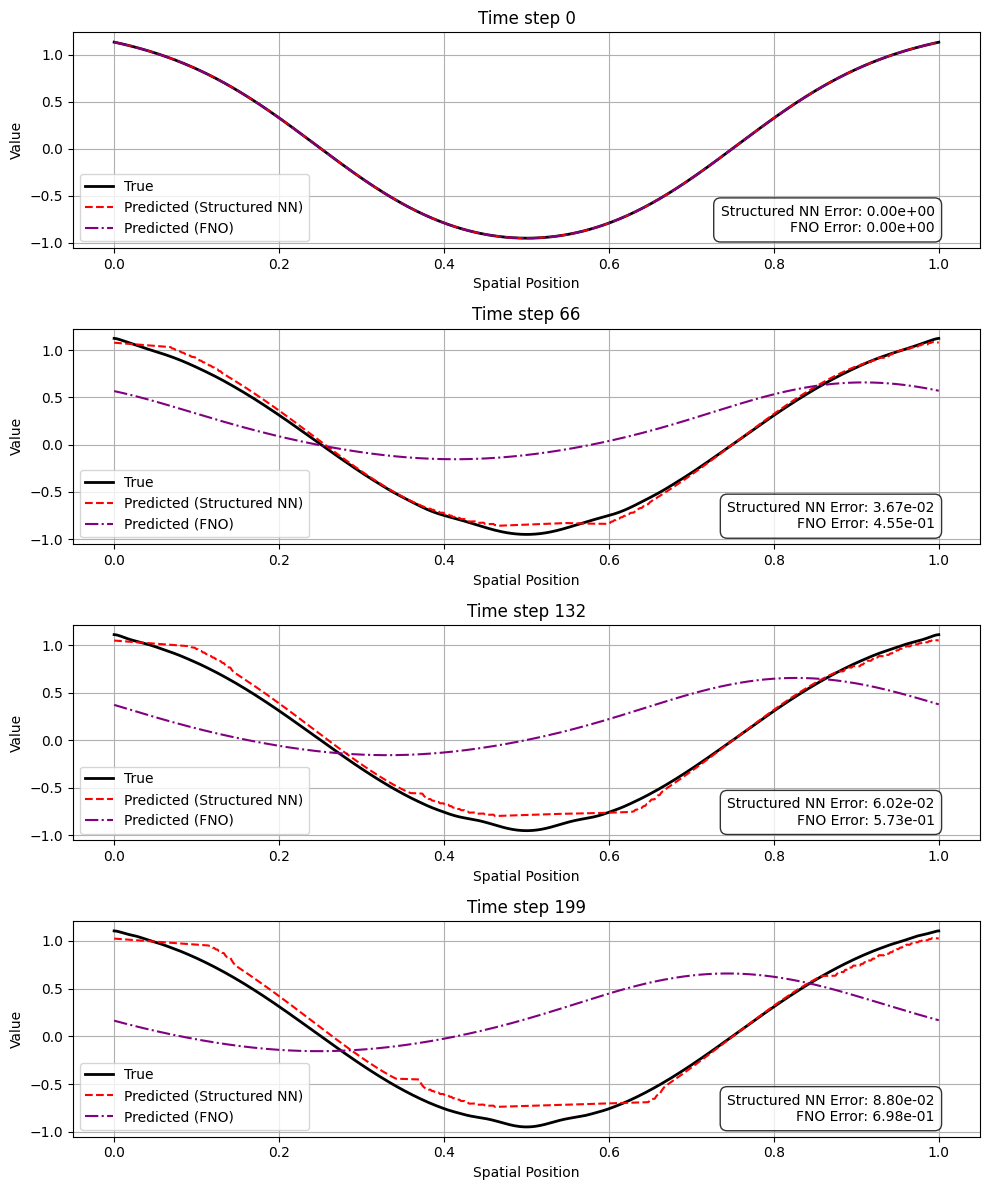

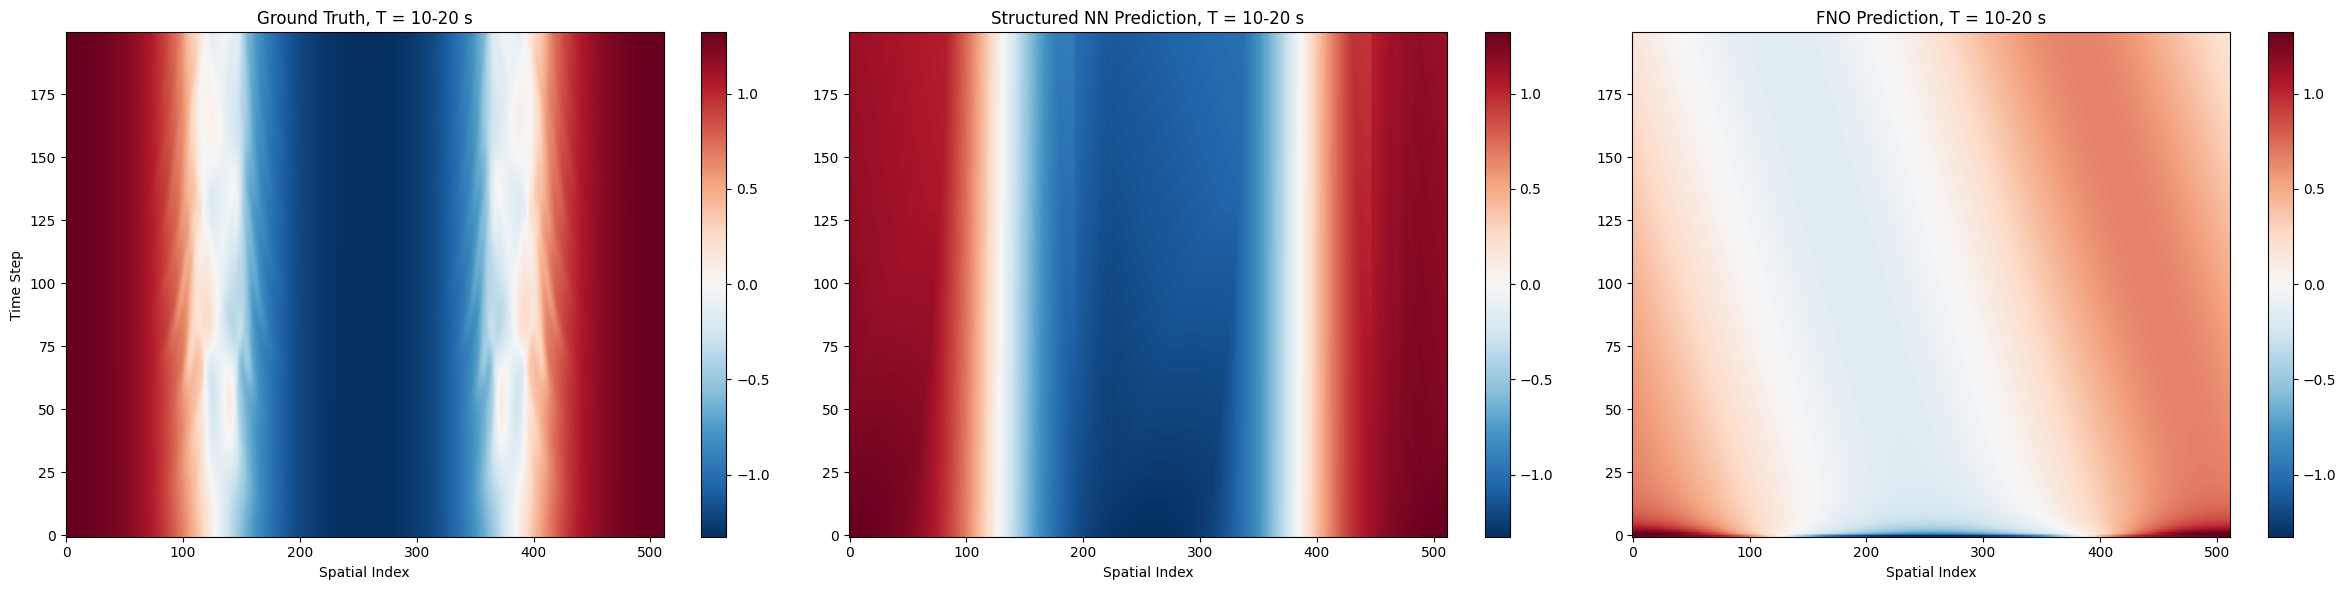

Sample 0, Time step 0:
  Average Absolute Error (Structured NN): 0.0000e+00
  Average Absolute Error (FNO): 0.0000e+00
Sample 0, Time step 66:
  Average Absolute Error (Structured NN): 8.0218e-02
  Average Absolute Error (FNO): 7.6242e-01
Sample 0, Time step 132:
  Average Absolute Error (Structured NN): 1.2181e-01
  Average Absolute Error (FNO): 8.6614e-01
Sample 0, Time step 199:
  Average Absolute Error (Structured NN): 1.4602e-01
  Average Absolute Error (FNO): 9.9570e-01


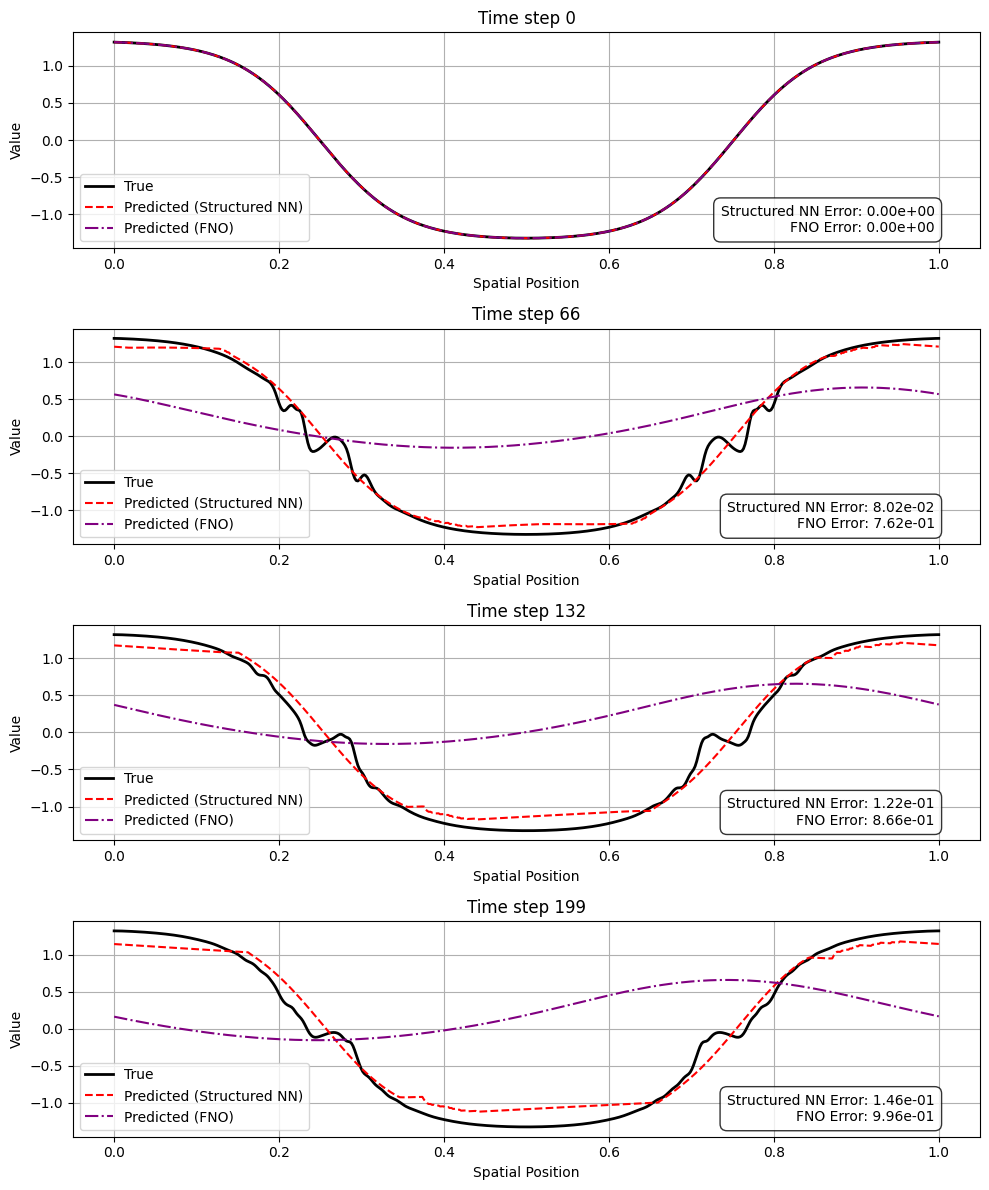

In [ ]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

# Assuming all necessary classes (StructuredAdvectionOperator, DiffusionOperator, RK4, FNO, SpectralConv1d) are defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Paths and Epochs to Load ---
structured_save_dir = './NonlinearStructuredAdvectionOperator'
fno_save_dir = './FNO_Model'

# Choose the epoch to load for each model
structured_epoch_to_load = 2000 # 2500 # Example epoch for structured model
fno_epoch_to_load = 200 # Example epoch for FNO model

# --- Constants (ensure these match your data and problem setup) ---
L = 1.0
nx = 512
dx = L / (nx - 1)
dt = 0.01
nt = 199
D = 1 / (5e5 * 2e-1) # Example diffusion coefficient
num_steps_eval = 199 # Number of steps to evaluate over

# --- Initialize and Load Structured Neural Network ---
firstOrder_structured = FirstOrderDerivative(h=dx).to(device).double()
diffusionOperator_structured = DiffusionOperator(h=dx, nu=D).to(device).double()
advectionOperator_structured = StructuredAdvectionOperator(dx=dx, hidden_dim=32).to(device).double()

structured_first_order_path = os.path.join(structured_save_dir, f'firstOrderDerivative_epoch_{structured_epoch_to_load}.pth')
structured_diffusion_path = os.path.join(structured_save_dir, f'diffusionOperator_epoch_{structured_epoch_to_load}.pth')
structured_advection_path = os.path.join(structured_save_dir, f'advectionOperator_epoch_{structured_epoch_to_load}.pth')

if os.path.exists(structured_first_order_path) and os.path.exists(structured_diffusion_path) and os.path.exists(structured_advection_path):
    firstOrder_structured.load_state_dict(torch.load(structured_first_order_path))
    diffusionOperator_structured.load_state_dict(torch.load(structured_diffusion_path))
    advectionOperator_structured.load_state_dict(torch.load(structured_advection_path))
    print(f"Loaded Structured NN model")
else:
    print(f"Structured NN model files not found for epoch {structured_epoch_to_load}. Please ensure the correct epoch is specified and the files exist.")

structured_rk_solver = RK4(diffusionOperator_structured, advectionOperator_structured, dt=dt).to(device)
firstOrder_structured.eval()
diffusionOperator_structured.eval()
advectionOperator_structured.eval()
structured_rk_solver.eval()


# --- Initialize and Load FNO Model ---
modes = 16
width = 32
fno_model = FNO(modes=modes, width=width, in_channels=1, out_channels=1, num_fourier_layers=4).to(device).double()
fno_model_path = os.path.join(fno_save_dir, f'fno_model_epoch_{fno_epoch_to_load}.pth')

if os.path.exists(fno_model_path):
    fno_model.load_state_dict(torch.load(fno_model_path))
    print(f"Loaded FNO model")
else:
    print(f"FNO model file not found for epoch {fno_epoch_to_load}. Please ensure the correct epoch is specified and the file exists.")

fno_model.eval()

# --- Plotting Function for Snapshots (Modified) ---
def plot_comparison_snapshots(u_true, u_pred_structured, u_pred_fno, x_axis, num_steps_eval, batch_id=0):
    time_steps_to_plot = [0, (num_steps_eval // 3), (2 * num_steps_eval // 3), num_steps_eval]

    fig, axs = plt.subplots(len(time_steps_to_plot), 1, figsize=(10, 3 * len(time_steps_to_plot)))
    if len(time_steps_to_plot) == 1:
        axs = [axs]

    for i, t in enumerate(time_steps_to_plot):
        true_snap = u_true[batch_id, t].detach().cpu().numpy()
        structured_pred_snap = u_pred_structured[batch_id, t].detach().cpu().numpy()
        fno_pred_snap = u_pred_fno[batch_id, t].detach().cpu().numpy()

        structured_error = structured_pred_snap - true_snap
        fno_error = fno_pred_snap - true_snap

        # Calculate average absolute error for printing and plotting
        avg_structured_error = np.mean(np.abs(structured_error))
        avg_fno_error = np.mean(np.abs(fno_error))

        print(f"Sample {batch_id}, Time step {t}:")
        print(f"  Average Absolute Error (Structured NN): {avg_structured_error:.4e}")
        print(f"  Average Absolute Error (FNO): {avg_fno_error:.4e}")

        axs[i].plot(x_axis, true_snap, label="True", color='black', linewidth=2)
        # Use different colors for structured and FNO predictions
        axs[i].plot(x_axis, structured_pred_snap, label=f"Predicted (Structured NN)", color='red', linestyle='--')
        # axs[i].fill_between(x_axis, structured_error, 0, color='salmon', alpha=0.5, label='Error (Structured NN)')

        axs[i].plot(x_axis, fno_pred_snap, label=f"Predicted (FNO)", color='purple', linestyle='-.')
        # axs[i].fill_between(x_axis, fno_error, 0, color='violet', alpha=0.5, label='Error (FNO)')

        axs[i].set_title(f"Time step {t}")
        axs[i].set_xlabel("Spatial Position") # Add xlabel
        axs[i].set_ylabel("Value")          # Add ylabel

        # Combine error annotations into a single text box and adjust position
        error_text = f'Structured NN Error: {avg_structured_error:.2e}\nFNO Error: {avg_fno_error:.2e}'
        axs[i].text(0.95, 0.2, error_text, transform=axs[i].transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))


        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


# --- Iterate over Test Samples and Plot ---
for sample in range(len(test_dataset)):
    # Get a sample from the test dataset
    # test_input, test_target = test_dataset[sample]
    test_input, test_target = train_dataset[sample]

    full_test_sequence = torch.cat((test_input.squeeze(1), test_target.squeeze(1)), dim=1) # [1, T_total_test, X]

    # Set the initial condition
    u0_test = full_test_sequence[:, 0, :].unsqueeze(1).to(device).double() # Shape: [1, 1, X]

    # --- Structured NN Prediction ---
    with torch.no_grad():
        # Structured NN expects [B, T, X] as input to RK4, but u0 is [B, 1, X].
        # We need to pass u0 as [B, X] to the RK4 forward method and specify steps.
        u_pred_structured, _, _ = structured_rk_solver(u0_test.squeeze(1), steps=num_steps_eval)
        # Ensure structured prediction has the correct shape [1, num_steps_eval + 1, nx]
        u_pred_structured = u_pred_structured.reshape(1, num_steps_eval + 1, nx)


    # --- FNO Prediction (Autoregressive) ---
    u_pred_fno_list = [u0_test.squeeze(1)] # Start with the initial condition [1, X]
    with torch.no_grad():
        current_u = u0_test
        for t in range(num_steps_eval):
            next_u = fno_model(current_u) # [1, 1, X]
            u_pred_fno_list.append(next_u.squeeze(1)) # Append [1, X] to list
            current_u = next_u # Set the prediction as the input for the next step
    u_pred_fno = torch.stack(u_pred_fno_list, dim=1) # Shape: [1, num_steps_eval + 1, X]


    # --- Get Ground Truth ---
    u_true_test = full_test_sequence[:, :(num_steps_eval + 1), :] # Shape: [1, num_steps_eval + 1, X]

    # --- Prepare for Plotting ---
    u_true_np = u_true_test.squeeze(0).cpu().numpy()
    # Correctly handle the structured NN prediction shape
    u_pred_structured_np = u_pred_structured.squeeze(0).cpu().numpy()
    u_pred_fno_np = u_pred_fno.squeeze(0).cpu().numpy()

    # Print shapes before calculating error
    # print(f"Sample {sample}: u_true_np shape: {u_true_np.shape}")
    # print(f"Sample {sample}: u_pred_structured_np shape: {u_pred_structured_np.shape}")
    # print(f"Sample {sample}: u_pred_fno_np shape: {u_pred_fno_np.shape}")


    # Compute absolute errors for heatmap
    error_structured_np = np.abs(u_true_np - u_pred_structured_np)
    error_fno_np = np.abs(u_true_np - u_pred_fno_np)

    # Determine shared color map limits for true and predicted plots
    # vmin = min(u_true_np.min(), u_pred_structured_np.min(), u_pred_fno_np.min())
    # vmax = max(u_true_np.max(), u_pred_structured_np.max(), u_pred_fno_np.max())
    vmin = min(u_true_np.min(), u_pred_structured_np.min())
    vmax = max(u_true_np.max(), u_pred_structured_np.max())

    # Determine shared color map limits for error plots
    error_vmin = 0
    # error_vmax = max(error_structured_np.max(), error_fno_np.max())
    error_vmax = error_structured_np.max()


    # --- Plot Heatmaps (Ground Truth, Structured NN Prediction, FNO Prediction) ---
    fig, axs = plt.subplots(1, 3, figsize=(24, 6)) # Increased figure size

    im0 = axs[0].imshow(u_true_np, aspect='auto', origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[0].set_title("Ground Truth, T = 10-20 s")
    axs[0].set_xlabel("Spatial Index")
    axs[0].set_ylabel("Time Step")
    fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(u_pred_structured_np, aspect='auto', origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[1].set_title(f"Structured NN Prediction, T = 10-20 s")
    axs[1].set_xlabel("Spatial Index")
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(u_pred_fno_np, aspect='auto', origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[2].set_title(f"FNO Prediction, T = 10-20 s")
    axs[2].set_xlabel("Spatial Index")
    fig.colorbar(im2, ax=axs[2])

    plt.tight_layout()
    plt.show()

    # # --- Plot Heatmaps (Structured NN Error, FNO Error) ---
    # fig, axs = plt.subplots(1, 2, figsize=(18, 6)) # Figure for error heatmaps

    # im0_err = axs[0].imshow(error_structured_np, aspect='auto', origin='lower', cmap='inferno', vmin=error_vmin, vmax=error_vmax)
    # axs[0].set_title(f"Structured NN Absolute Error, T = 10-20 s")
    # axs[0].set_xlabel("Spatial Index")
    # axs[0].set_ylabel("Time Step")
    # fig.colorbar(im0_err, ax=axs[0])

    # im1_err = axs[1].imshow(error_fno_np, aspect='auto', origin='lower', cmap='inferno', vmin=error_vmin, vmax=error_vmax)
    # axs[1].set_title(f"FNO Absolute Error, T = 10-20 s")
    # axs[1].set_xlabel("Spatial Index")
    # fig.colorbar(im1_err, ax=axs[1])

    # plt.tight_layout()
    # plt.show()


    # --- Plot Snapshots ---
    x = torch.linspace(0, L, nx).cpu().numpy()
    plot_comparison_snapshots(u_true_test, u_pred_structured, u_pred_fno, x_axis=x, num_steps_eval=num_steps_eval, batch_id=0)

Loaded Structured NN model
Loaded FNO model
Sample 0, Time step 0:
  Average Absolute Error (Structured NN): 0.0000e+00
  Average Absolute Error (FNO): 0.0000e+00
Sample 0, Time step 99:
  Average Absolute Error (Structured NN): 5.8671e-01
  Average Absolute Error (FNO): 6.3850e-01
Sample 0, Time step 199:
  Average Absolute Error (Structured NN): 5.9560e-01
  Average Absolute Error (FNO): 7.7224e-01


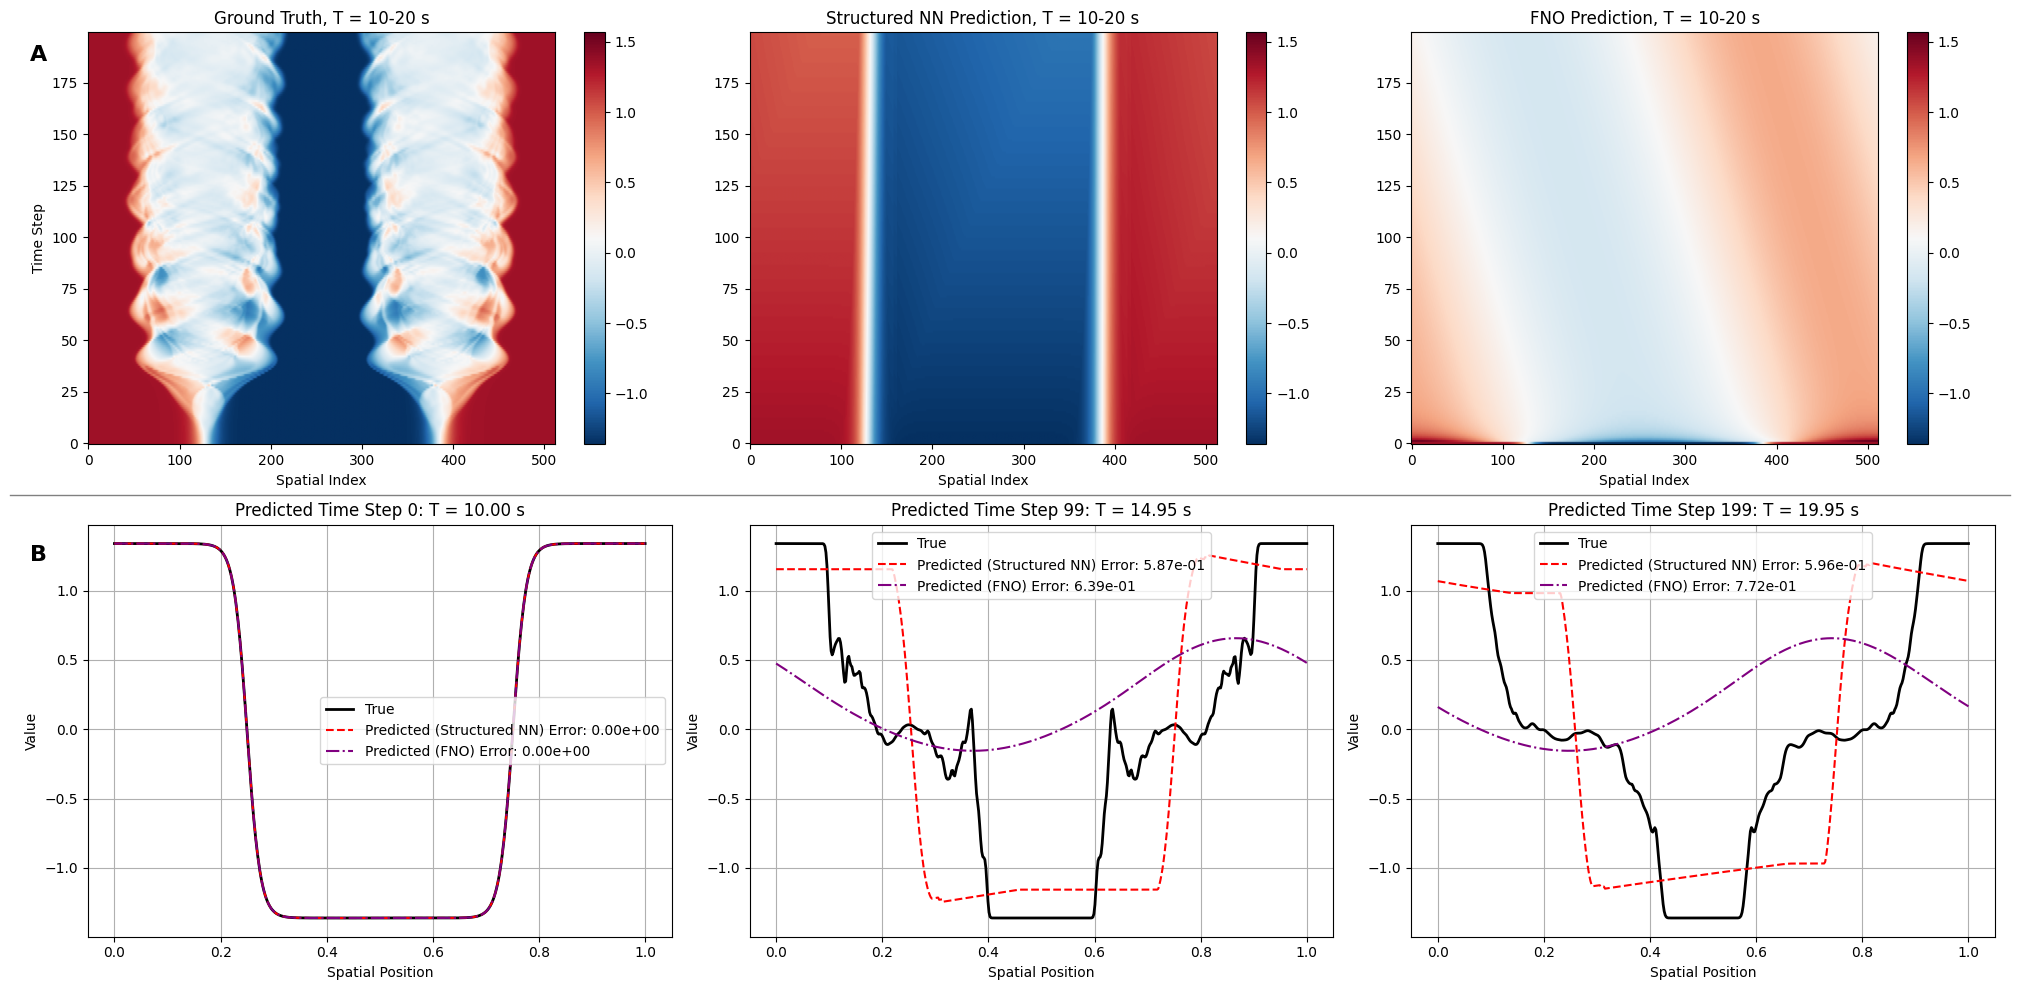

Sample 1, Time step 0:
  Average Absolute Error (Structured NN): 0.0000e+00
  Average Absolute Error (FNO): 0.0000e+00
Sample 1, Time step 99:
  Average Absolute Error (Structured NN): 5.3536e-02
  Average Absolute Error (FNO): 5.1102e-01
Sample 1, Time step 199:
  Average Absolute Error (Structured NN): 9.4233e-02
  Average Absolute Error (FNO): 6.9733e-01


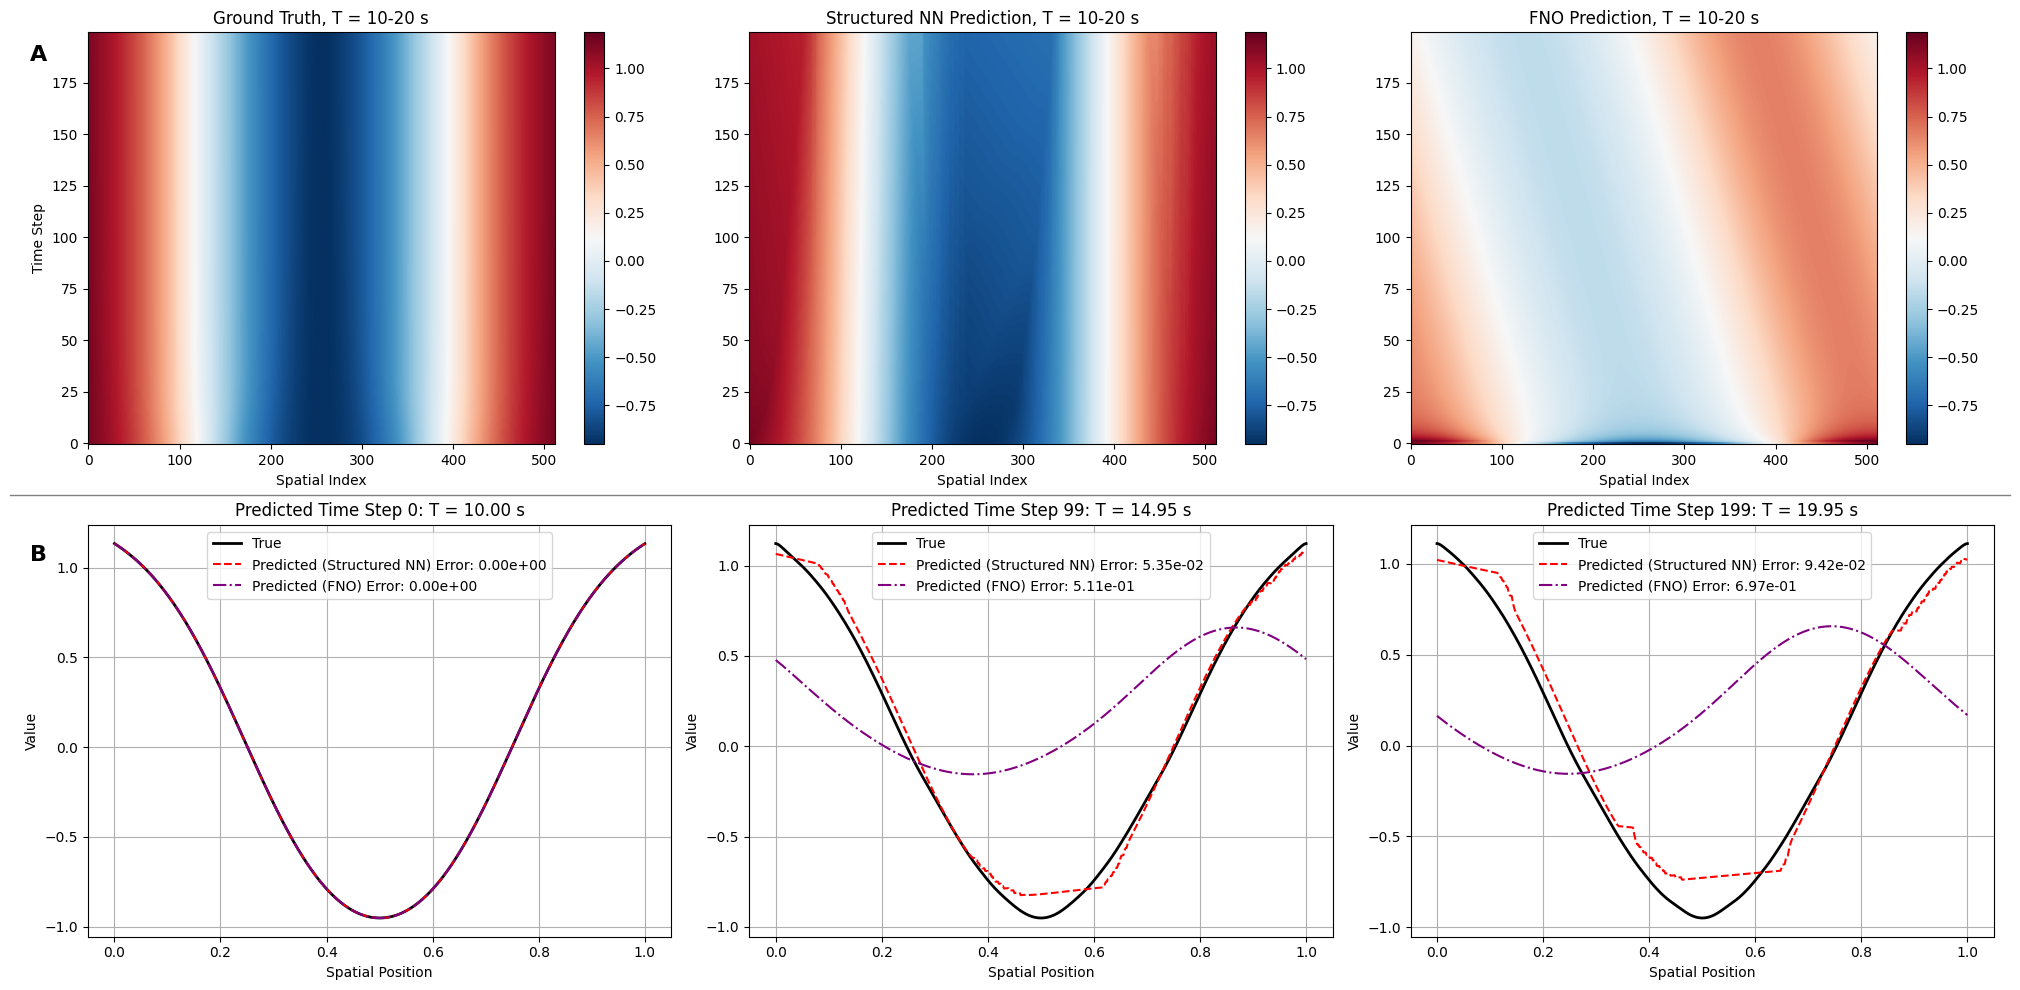

Sample 2, Time step 0:
  Average Absolute Error (Structured NN): 0.0000e+00
  Average Absolute Error (FNO): 0.0000e+00
Sample 2, Time step 99:
  Average Absolute Error (Structured NN): 4.7017e-02
  Average Absolute Error (FNO): 5.1085e-01
Sample 2, Time step 199:
  Average Absolute Error (Structured NN): 8.7964e-02
  Average Absolute Error (FNO): 6.9783e-01


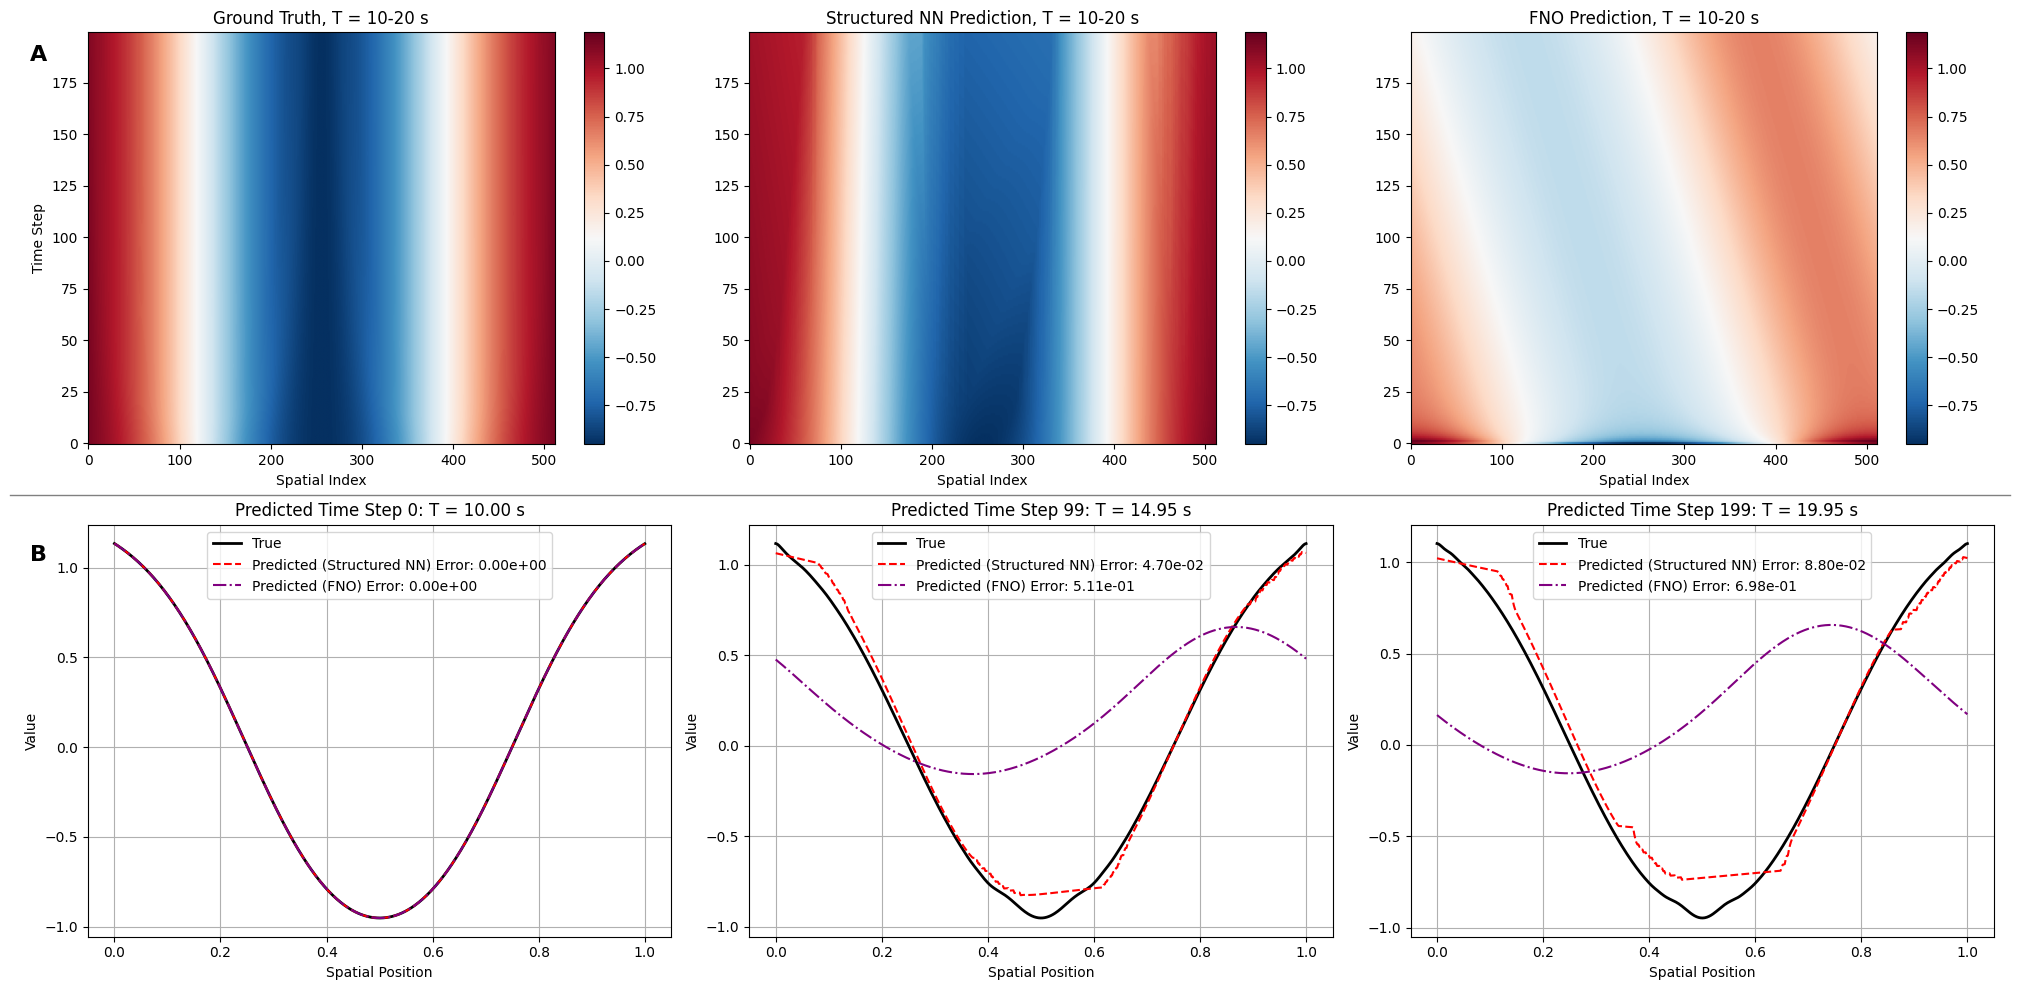

Sample 3, Time step 0:
  Average Absolute Error (Structured NN): 0.0000e+00
  Average Absolute Error (FNO): 0.0000e+00
Sample 3, Time step 99:
  Average Absolute Error (Structured NN): 8.6940e-02
  Average Absolute Error (FNO): 8.1152e-01
Sample 3, Time step 199:
  Average Absolute Error (Structured NN): 1.4602e-01
  Average Absolute Error (FNO): 9.9570e-01


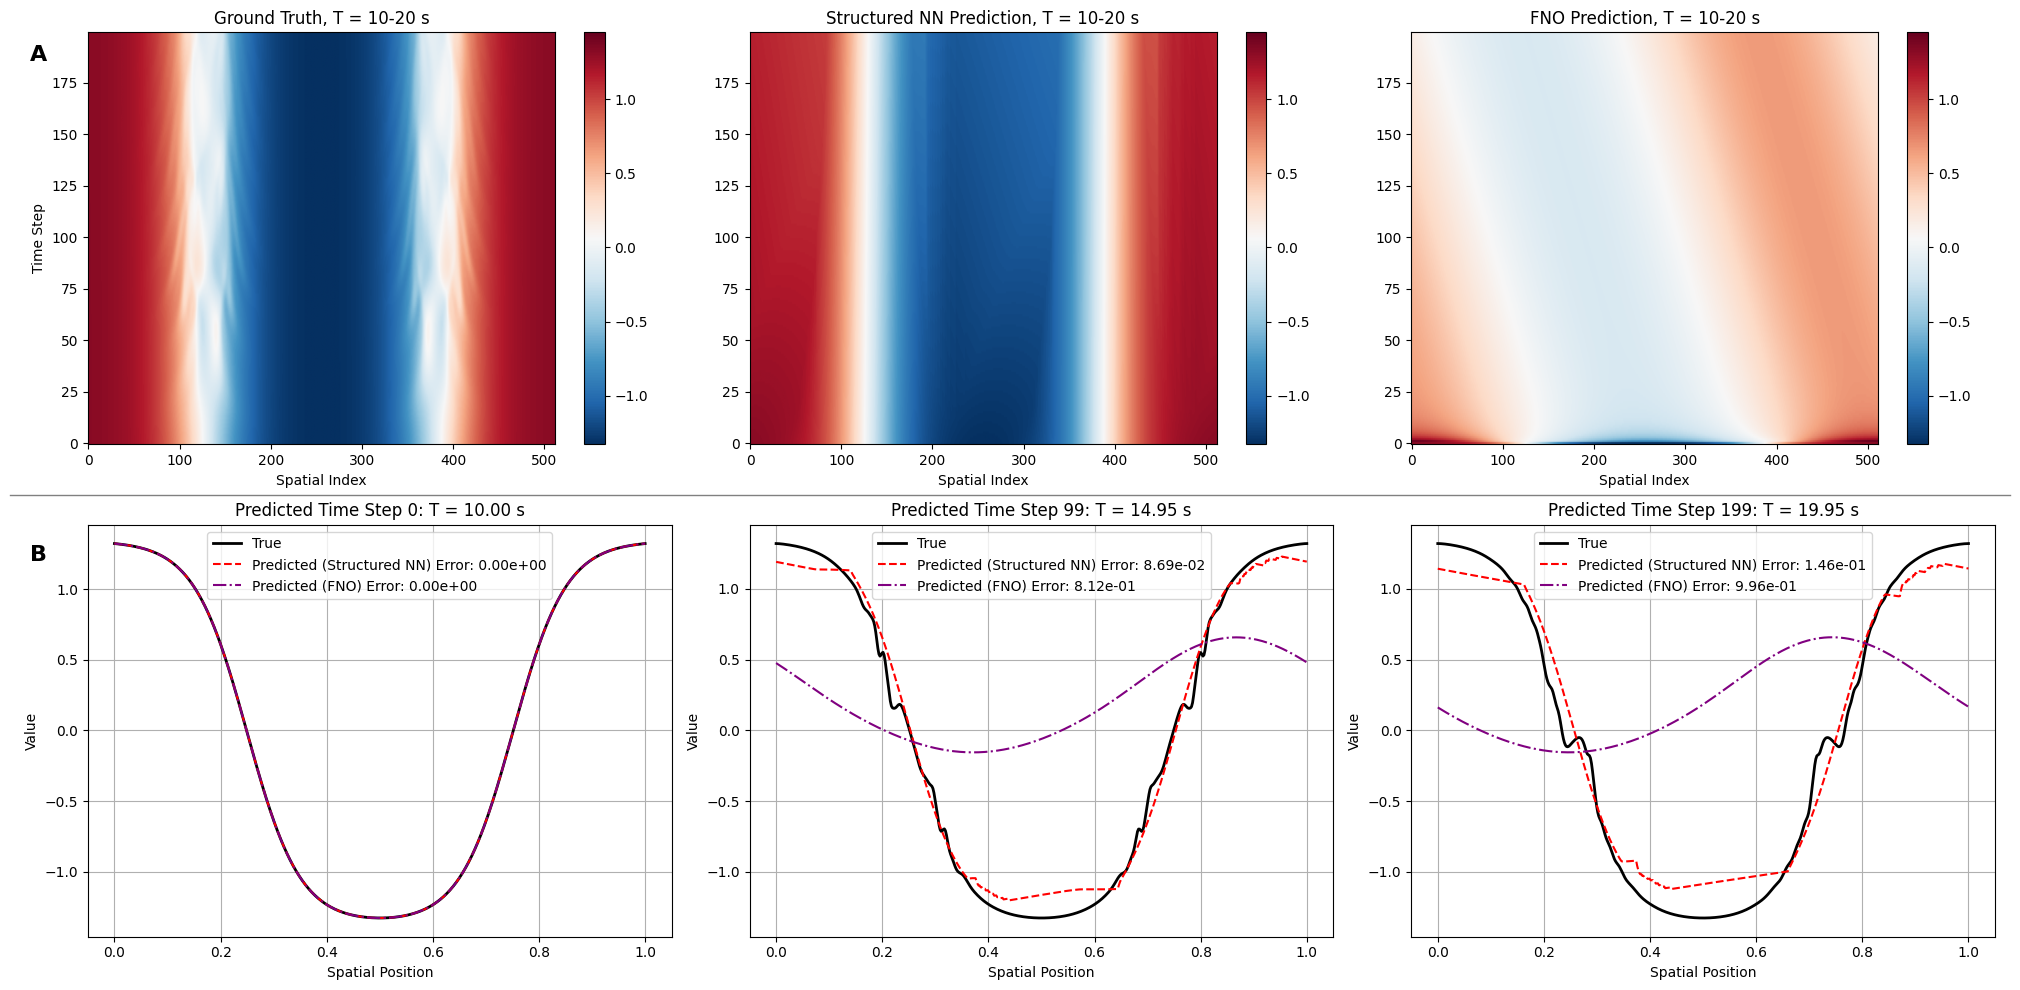

In [22]:
# --- Paths and Epochs to Load ---
structured_save_dir = '/content/drive/MyDrive/Thesis/NonlinearStructuredAdvectionOperator'
fno_save_dir = '/content/drive/MyDrive/Thesis/FNO_Model'

# Choose the epoch to load for each model
structured_epoch_to_load = 2000 # 2500 # Example epoch for structured model
fno_epoch_to_load = 200 # Example epoch for FNO model

# --- Constants (ensure these match your data and problem setup) ---
L = 1.0
nx = 512
dx = L / (nx - 1)
dt = 0.01
nt = 199
D = 1 / (5e5 * 2e-1) # Example diffusion coefficient
num_steps_eval = 199 # Number of steps to evaluate over

# --- Initialize and Load Structured Neural Network ---
firstOrder_structured = FirstOrderDerivative(h=dx).to(device).double()
diffusionOperator_structured = DiffusionOperator(h=dx, nu=D).to(device).double()
advectionOperator_structured = StructuredAdvectionOperator(dx=dx, hidden_dim=32).to(device).double()

structured_first_order_path = os.path.join(structured_save_dir, f'firstOrderDerivative_epoch_{structured_epoch_to_load}.pth')
structured_diffusion_path = os.path.join(structured_save_dir, f'diffusionOperator_epoch_{structured_epoch_to_load}.pth')
structured_advection_path = os.path.join(structured_save_dir, f'advectionOperator_epoch_{structured_epoch_to_load}.pth')

if os.path.exists(structured_first_order_path) and os.path.exists(structured_diffusion_path) and os.path.exists(structured_advection_path):
    firstOrder_structured.load_state_dict(torch.load(structured_first_order_path))
    diffusionOperator_structured.load_state_dict(torch.load(structured_diffusion_path))
    advectionOperator_structured.load_state_dict(torch.load(structured_advection_path))
    print(f"Loaded Structured NN model")
else:
    print(f"Structured NN model files not found for epoch {structured_epoch_to_load}. Please ensure the correct epoch is specified and the files exist.")

structured_rk_solver = RK4(diffusionOperator_structured, advectionOperator_structured, dt=dt).to(device)
firstOrder_structured.eval()
diffusionOperator_structured.eval()
advectionOperator_structured.eval()
structured_rk_solver.eval()


# --- Initialize and Load FNO Model ---
modes = 16
width = 32
fno_model = FNO(modes=modes, width=width, in_channels=1, out_channels=1, num_fourier_layers=4).to(device).double()
fno_model_path = os.path.join(fno_save_dir, f'fno_model_epoch_{fno_epoch_to_load}.pth')

if os.path.exists(fno_model_path):
    fno_model.load_state_dict(torch.load(fno_model_path))
    print(f"Loaded FNO model")
else:
    print(f"FNO model file not found for epoch {fno_epoch_to_load}. Please ensure the correct epoch is specified and the file exists.")

fno_model.eval()

# --- Plotting Function for combined heatmaps and snapshots ---
def plot_combined_results(u_true, u_pred_structured, u_pred_fno, x_axis, num_steps_eval, sample_id=0):
    # time_steps_to_plot = [0, (num_steps_eval // 3), (2 * num_steps_eval // 3), num_steps_eval]
    time_steps_to_plot = [0, (num_steps_eval // 2), num_steps_eval]

    # Create a figure with subplots: 3 heatmaps on top, and 3 snapshots below
    # Adjust figsize to accommodate 3 snapshots
    fig, axs = plt.subplots(2, 3, figsize=(20, 10), gridspec_kw={'height_ratios': [1, 1]})

    # --- Plot Heatmaps ---
    vmin = min(u_true.min(), u_pred_structured.min(), u_pred_fno.min())
    vmax = max(u_true.max(), u_pred_structured.max(), u_pred_fno.max())

    im0 = axs[0, 0].imshow(u_true.squeeze(0).cpu().numpy(), aspect='auto', origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[0, 0].set_title("Ground Truth, T = 10-20 s")
    axs[0, 0].set_xlabel("Spatial Index")
    axs[0, 0].set_ylabel("Time Step")
    fig.colorbar(im0, ax=axs[0, 0])

    im1 = axs[0, 1].imshow(u_pred_structured.squeeze(0).cpu().numpy(), aspect='auto', origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[0, 1].set_title(f"Structured NN Prediction, T = 10-20 s")
    axs[0, 1].set_xlabel("Spatial Index")
    fig.colorbar(im1, ax=axs[0, 1])

    im2 = axs[0, 2].imshow(u_pred_fno.squeeze(0).cpu().numpy(), aspect='auto', origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[0, 2].set_title(f"FNO Prediction, T = 10-20 s")
    axs[0, 2].set_xlabel("Spatial Index")
    fig.colorbar(im2, ax=axs[0, 2])

    # Add label "A" to the top section
    fig.text(0.01, 0.95, 'A', fontsize=16, fontweight='bold', va='top', ha='left', transform=fig.transFigure)


    # --- Plot Snapshots ---
    # Adjust snapshot plotting to use the second row of subplots
    snapshot_axs = axs[1, :] # Select the second row

    # Iterate through the time steps to plot, but ensure we don't exceed the number of snapshot subplots
    for i, t in enumerate(time_steps_to_plot[:len(snapshot_axs)]):
        true_snap = u_true[0, t].detach().cpu().numpy()
        structured_pred_snap = u_pred_structured[0, t].detach().cpu().numpy()
        fno_pred_snap = u_pred_fno[0, t].detach().cpu().numpy()

        structured_error = structured_pred_snap - true_snap
        fno_error = fno_pred_snap - true_snap

        # Calculate average absolute error for printing and plotting
        avg_structured_error = np.mean(np.abs(structured_error))
        avg_fno_error = np.mean(np.abs(fno_error))

        print(f"Sample {sample_id}, Time step {t}:")
        print(f"  Average Absolute Error (Structured NN): {avg_structured_error:.4e}")
        print(f"  Average Absolute Error (FNO): {avg_fno_error:.4e}")

        snapshot_axs[i].plot(x_axis, true_snap, label="True", color='black', linewidth=2)
        # Include error in the legend label
        snapshot_axs[i].plot(x_axis, structured_pred_snap, label=f"Predicted (Structured NN) Error: {avg_structured_error:.2e}", color='red', linestyle='--')
        snapshot_axs[i].plot(x_axis, fno_pred_snap, label=f"Predicted (FNO) Error: {avg_fno_error:.2e}", color='purple', linestyle='-.')

        snapshot_axs[i].set_title(f"Predicted Time Step {t}: T = {10 + t*0.05:.2f} s")
        snapshot_axs[i].set_xlabel("Spatial Position")
        snapshot_axs[i].set_ylabel("Value")

        snapshot_axs[i].legend()
        snapshot_axs[i].grid(True)


    # Hide any unused subplots in the second row if time_steps_to_plot is shorter than the number of snapshot subplots
    for i in range(len(time_steps_to_plot), len(snapshot_axs)):
         fig.delaxes(snapshot_axs[i])

    # Add label "B" to the bottom section
    fig.text(0.01, 0.45, 'B', fontsize=16, fontweight='bold', va='top', ha='left', transform=fig.transFigure)


    # Add a horizontal line to separate heatmaps and snapshots
    # Get the y-coordinate in figure coordinates for the line.
    # The heatmaps occupy the top row (index 0), and snapshots the bottom (index 1).
    # The line should be placed between row 0 and row 1.
    # The y-coordinate of the bottom of the top row is 0.5 (since height_ratios are 1, 1).
    # The y-coordinate of the top of the bottom row is 0.5.
    # We can add the line at y=0.5 in figure coordinates.
    fig.add_artist(plt.Line2D([0, 1], [0.5, 0.5], color='gray', linestyle='-', lw=1, transform=fig.transFigure))


    plt.tight_layout()
    plt.show()


# --- Iterate over Test Samples and Plot ---
for sample in range(len(test_dataset)):
    # Get a sample from the test dataset
    # test_input, test_target = test_dataset[sample]
    test_input, test_target = train_dataset[sample]


    full_test_sequence = torch.cat((test_input.squeeze(1), test_target.squeeze(1)), dim=1) # [1, T_total_test, X]

    # Set the initial condition
    u0_test = full_test_sequence[:, 0, :].unsqueeze(1).to(device).double() # Shape: [1, 1, X]

    # --- Structured NN Prediction ---
    with torch.no_grad():
        u_pred_structured, _, _ = structured_rk_solver(u0_test.squeeze(1), steps=num_steps_eval)
        u_pred_structured = u_pred_structured.reshape(1, num_steps_eval + 1, nx)

    # --- FNO Prediction (Autoregressive) ---
    u_pred_fno_list = [u0_test.squeeze(1)]
    with torch.no_grad():
        current_u = u0_test
        for t in range(num_steps_eval):
            next_u = fno_model(current_u)
            u_pred_fno_list.append(next_u.squeeze(1))
            current_u = next_u
    u_pred_fno = torch.stack(u_pred_fno_list, dim=1)

    # --- Get Ground Truth ---
    u_true_test = full_test_sequence[:, :(num_steps_eval + 1), :]

    # --- Plot Combined Results ---
    x = torch.linspace(0, L, nx).cpu().numpy()
    plot_combined_results(u_true_test, u_pred_structured, u_pred_fno, x_axis=x, num_steps_eval=num_steps_eval, sample_id=sample)